# Oscillator model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import epde.interface.interface as epde_alg
from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens

In [2]:
#start_date, end_date = '2020-03-01', '2020-12-01'
#start_date, end_date = '2021-03-01', '2021-12-01'
start_date, end_date = '2022-03-01', '2022-12-01'

In [3]:
data = pd.read_csv('../DATA-MINING/OTHER-DATA/TRANS/trans_big.csv')
data['TRANS_DATE'] = pd.to_datetime(data.date)
vallab = ['food', 'outfit', 'dwelling', 'health',
          'beauty', 'remote', 'travel', 'money',
          'kids', 'nonfood', 'telecom', 'fun',
          'charity', 'misc']
data = data[np.in1d(data.group.values, vallab)]
data.sort_values(by='date', inplace=True, ignore_index=True)
data.head()

,client,card,date,amt,mcc,group,value,TRANS_DATE
0,390989,3048567,2018-01-01,878.00,5814,food,survival,2018-01-01
1,1496081,2543555,2018-01-01,495.60,5499,food,survival,2018-01-01
2,2028714,2725479,2018-01-01,30000.00,6538,money,money,2018-01-01
3,1049186,366339,2018-01-01,619.00,5499,food,survival,2018-01-01
4,2625093,3267785,2018-01-01,1596.36,5411,food,survival,2018-01-01


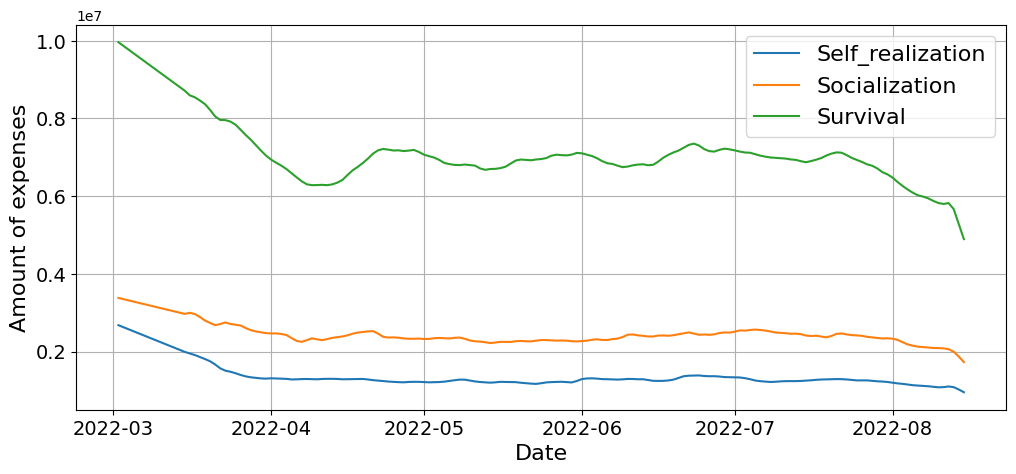

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
data['idate'] = pd.to_datetime(data.date)

d = data[(data.date>start_date)&(data.date<end_date)] \
    .groupby(['idate','value']) \
    .amt.sum().unstack() \
    .fillna(method='bfill')

plt.figure(figsize=(12,5))
for c in d.columns[1:]:
    sdec = seasonal_decompose(d[c],
                              period=14,
                              model='additive',
                              two_sided=False,
                              extrapolate_trend='freq')
    plt.plot(sdec.trend, label=c.capitalize())

plt.legend(fontsize=16)    
plt.grid()
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Date',size=16)
plt.ylabel('Amount of expenses',size=16)
plt.show()

In [5]:
d.head()

value,money,self_realization,socialization,survival
idate,,,,
2022-03-02,13807442.36,1794783.39,2954829.12,8195924.01
2022-03-03,13788669.51,1980933.17,3095617.67,9535579.24
2022-03-04,13846187.41,2242972.59,4041611.55,9375787.89
2022-03-05,13261554.99,2344497.13,3397493.56,10253096.36
2022-03-06,5274828.84,2164844.29,2986573.52,9465664.36


## Calender

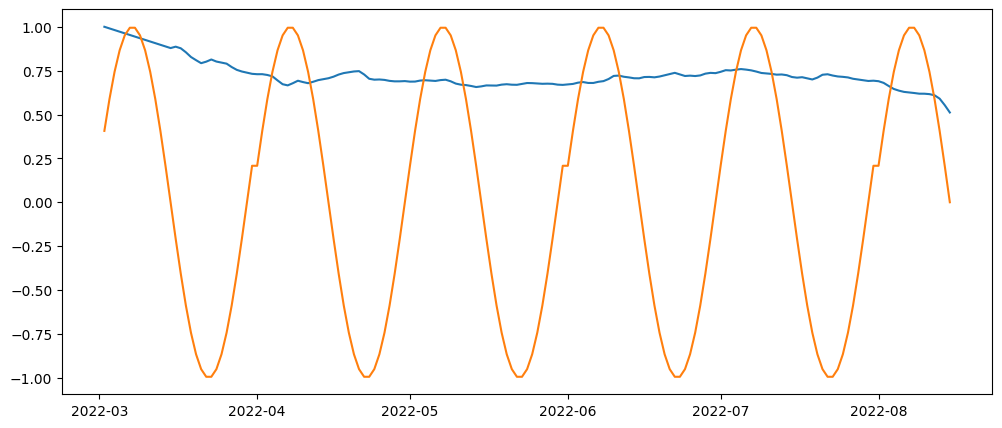

In [6]:
u = seasonal_decompose(d['socialization'],
                       period=14,
                       model='additive',
                       two_sided=False,
                       extrapolate_trend='freq').trend
u /= u.max() # normalization
dsin = np.sin(u.index.day.values*2*np.pi / 30)
dcos = np.cos(u.index.day.values*2*np.pi / 30)

t = np.linspace(0, len(u), len(u))
plt.figure(figsize=(12,5))
plt.plot(u)
plt.plot(pd.Series(dsin, index=u.index))

## EPDE parameter search

In [7]:
boundary = 50
dimensionality = u.ndim
grids = np.meshgrid(t)

epde_search_obj = epde_alg.epde_search(use_solver=False,
                                       eq_search_iter=100,
                                       dimensionality=dimensionality)
epde_search_obj.fit(data=u.values, max_deriv_order=(2), boundary=boundary, 
                    equation_terms_max_number=3, equation_factors_max_number=1,
                    coordinate_tensors=grids, eq_sparsity_interval=(1e-8, 5.0),
                    deriv_method='poly', deriv_method_kwargs={'smooth': True, 'grid': grids},
                    memory_for_cache=25, prune_domain=False)

res = epde_search_obj.equation_search_results(only_print=0, level_num=2)[0][0]
a, b, c = -res.structure[0].weights_final

print(f"a: {a}\nb: {b}")

Deriv orders after definition [[None], [0], [0, 0]]
Executing on grid with uniform nodes:
167
Start: 2023-04-05 18:00:31.995931 ; Finish: 2023-04-05 18:00:32.074656
Preprocessing runtime: 0:00:00.078725
set grids parameter is True
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
initial_shape (167,) derivs_tensor.shape (167, 2)
var_tensor.shape (167,) (67,) 50
completed grid cache with 1 tensors with labels dict_keys(['0'])
['u', 'du/dx1', 'd^2u/dx1^2']
The cardinality of defined token pool is [3]
Among them, the pool contains [3]
Creating new equation, sparsity value [2.73298318e-08]
Equation created <class 'epde.structure.SoEq'>
New solution accepted, confirmed 1/3 solutions.
Creating new equation, sparsity value [1.50249425e-06]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.00195646]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.00972893]
Equation created <class 'epde.structure.SoEq'>
Creating new equ

Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [2.3319198]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.10179544]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [4.20802878e-05]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.00014871]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [1.89796127e-06]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [1.81646328e-08]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [4.05344529e-05]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [1.958934e-08]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.05415026]
Equation created <class 'epde.structure.SoEq'>
Creating new equation, sparsity value [0.04233642]
Equ

Oscillator function:
$$X'' + aX' + bX = f(t)$$
where $X$ is the time series, $X'$ and $X''$ are its time derivatives, $a$ and $b$ are model parameters.

If $Z = X'$, then:
$$\begin{cases}
X'(t) = Z(t) + g(t) \\
Z'(t) = f(t) - aZ(t) - bX
\end{cases} \qquad g(t) \equiv 0$$

Vectorially speaking:
$$\frac{d}{dt} \begin{bmatrix} X \\ Z \end{bmatrix} = 
\begin{bmatrix} 0 & 1 \\ -b & -a \end{bmatrix} \cdot
\begin{bmatrix} X \\ Z \end{bmatrix} + 
\begin{bmatrix} g(t) \\ f(t) \end{bmatrix} \qquad g(t) \equiv 0$$

In this model, however, $g(t) \neq 0$, thus:
$$\underbrace{\frac{d}{dt} \begin{bmatrix} X \\ Z \end{bmatrix}}_{Y'} = 
\underbrace{\begin{bmatrix} 0 & 1 \\ -b & -a \end{bmatrix}}_{A} \cdot
\underbrace{\begin{bmatrix} X \\ Z \end{bmatrix}}_{Y} + 
\underbrace{\begin{bmatrix} g(t) \\ f(t) \end{bmatrix}}_{B}$$
$$Y' = A \cdot Y + B(t)$$

## News as initial state

In [8]:
news_path = '../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv'

news = pd.read_csv(news_path, sep=',', on_bad_lines='skip')
news.rename(columns={"Unnamed: 0": "date"}, inplace=True)
news['date'] = pd.to_datetime(news['date'])
news.sort_values(by='date', inplace=True, ignore_index=True)
cols = [1, 2]
news.drop(news.columns[cols], axis=1, inplace=True)

# Linear interpolation for daily values
new_idx = pd.date_range(start=data['TRANS_DATE'].min(),
                        end=data['TRANS_DATE'].max(),
                        freq='D')
news.set_index('date', inplace=True)
news = news.reindex(news.index.union(new_idx)).interpolate(method='time')
news = news.reindex(new_idx)

news = news[(news.index>start_date)&(news.index<end_date)]

news.head()

,1_полиция_полицейски_наркотик,2_коронавиру_сутки_человек,3_год_2022_2020,4_белоруссия_ленинградс_область,5_мотоциклис_велосипеди_велосипед,6_парковка_парк_платный,7_театр_спектакль_мариинский,8_qr_код_цифровой,9_маска_носить_медицински,10_кафе_ресторан_кофе,...,39_стихотворе_стих_шнур,40_ситуация_стабилизац_стабилизир,41_бетономеша_бетонный_бетон,42_коррупция_борьба_коррупцион,43_четырехдне_рабочий_неделя,44_интернацио_парк_референдум,45_страховой_страховщик_страховка,46_оповещение_система_проверка,47_треугольни_красный_пожар,48_биометриче_биометрия_данные
2022-03-02,68.240345,81.857338,51.687869,29.129941,13.545661,7.399364,21.094048,11.659246,26.621081,21.291686,...,1.0,1.671362,1.373239,2.338028,3.992958,1.0,1.923217,3.685446,6.362676,1.0
2022-03-03,67.748296,80.761624,51.859306,28.931243,13.560806,8.000606,21.188096,11.863093,26.181130,20.958958,...,1.0,1.660407,1.377347,2.327074,4.009390,1.0,1.893382,3.641628,6.391432,1.0
2022-03-04,67.256247,79.665909,52.030744,28.732546,13.575950,8.601848,21.282144,12.066939,25.741178,20.626231,...,1.0,1.649452,1.381455,2.316119,4.025822,1.0,1.863547,3.597809,6.420188,1.0
2022-03-05,66.764198,78.570195,52.202181,28.533848,13.591095,9.203090,21.376193,12.270786,25.301227,20.293503,...,1.0,1.638498,1.385563,2.305164,4.042254,1.0,1.833712,3.553991,6.448944,1.0
2022-03-06,66.272149,77.474481,52.373618,28.335151,13.606240,9.804331,21.470241,12.474633,24.861275,19.960775,...,1.0,1.627543,1.389671,2.294210,4.058685,1.0,1.803877,3.510172,6.477700,1.0


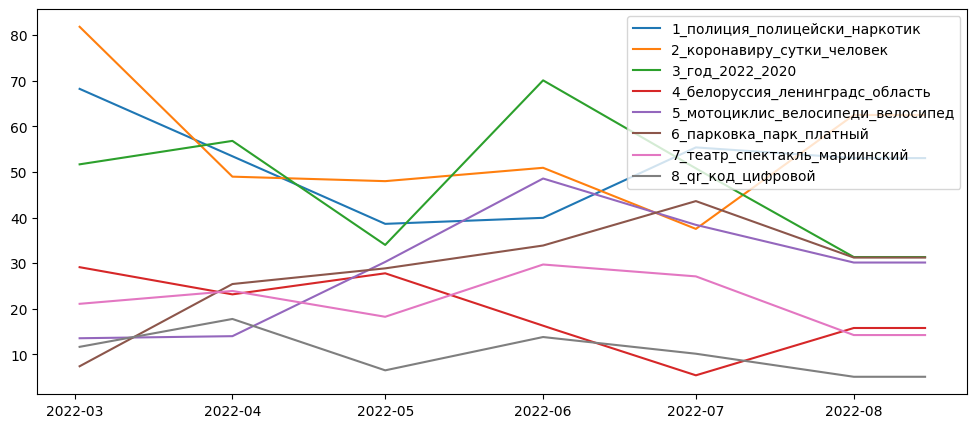

In [9]:
plt.figure(figsize=(12,5))
plt.plot(news.iloc[:,:8]);
plt.legend(news.columns[:8]);

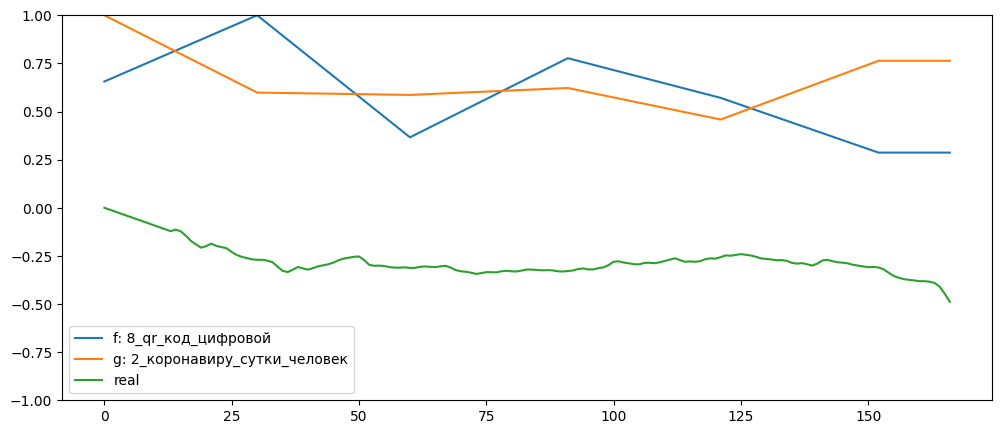

In [21]:
fi, gi = 7, 1

plt.figure(figsize=(12,5))
plt.plot((news.iloc[:,fi]/news.iloc[:,fi].max()).to_list(), label=f"f: {news.columns[fi]}");
plt.plot((news.iloc[:,gi]/news.iloc[:,gi].max()).to_list(), label=f"g: {news.columns[gi]}");
plt.plot(list(u.values-u.values[0]), label="real")
plt.ylim([-1, 1])
plt.plot()
plt.legend();

## Runge-Kutta 4 solution

x_bias: 6.766069609007196	cos_bias: 0.8005974404081517	dx_bias: 0.5325794413766632	loss: 9586559484.04162%x_bias: -14.49241687388078	cos_bias: 9.555954500663892	dx_bias: 0.7154487896470045	loss: 7767908685.637086%x_bias: 11.151729704639145	cos_bias: -0.24844733729846435	dx_bias: 0.22419158076928503	loss: 11264422742.460663%

x_bias: 10.707970575529306	cos_bias: -2.7899347888553203	dx_bias: 0.5538521343755298	loss: 13223318685.051088%

x_bias: 11.875803079852393	cos_bias: 8.583968846451972	dx_bias: 0.6156800776798551	loss: 14476244384.985966%x_bias: -4.717446827517881	cos_bias: 3.242961350750675	dx_bias: 0.1587136751044287	loss: 3048599704.76564%

x_bias: -10.435240296186512	cos_bias: 8.064645946013586	dx_bias: 0.3209492206415822	loss: 6969222353.002248%
x_bias: -10.105392135197564	cos_bias: 0.5014881338048891	dx_bias: 0.7884990884219835	loss: 3289520652.4627333%
x_bias: -0.024845350447746384	cos_bias: -3.8781779591425023	dx_bias: 0.921831478062415	loss: 6479809844.646145%x_bias: -13.51

x_bias: -14.135463611973195	cos_bias: -4.347085999357343	dx_bias: 0.9803653930041853	loss: 5371088038.84558%
x_bias: -5.133785438659558	cos_bias: 2.673319616048569	dx_bias: 0.8342492839094233	loss: 1315043872.161069%
x_bias: -14.178627553966594	cos_bias: 8.78723952897504	dx_bias: 0.19777047109724932	loss: 11095885660.656803%
x_bias: -1.3545074403430823	cos_bias: -5.84787642052081	dx_bias: 0.5335713012745703	loss: 2646991420.5106215%
x_bias: -3.435088581289868	cos_bias: -4.79206061809052	dx_bias: 0.297922077894395	loss: 824892936.4450083%x_bias: 9.296235966096479	cos_bias: 6.360669398042656	dx_bias: 0.2913774509077629	loss: 10007591172.793985%

x_bias: -3.9867307784106556	cos_bias: 5.077229247250145	dx_bias: 0.7782108555102278	loss: 1880071330.3296764%
x_bias: -6.348387308882154	cos_bias: -6.682664145312581	dx_bias: 0.3710553372419372	loss: 2814877547.1004934%
x_bias: -2.088522447740751	cos_bias: -5.009808595210784	dx_bias: 0.028241080304963473	loss: 1533130403.4755838%
x_bias: -8.39196

x_bias: -6.9691181883745195	cos_bias: -5.569897144105506	dx_bias: 0.9573299166113067	loss: 719249637.6932043%
x_bias: -4.850137280844514	cos_bias: -0.12614502461996557	dx_bias: 0.6666799179323483	loss: 439593499.4074338%
x_bias: -1.2322848855333812	cos_bias: 2.8972568161956276	dx_bias: 0.9279604106931635	loss: 5357312460.320645%
x_bias: -2.4247944203328666	cos_bias: -2.588056462469228	dx_bias: 0.30138998711193227	loss: 40058068.6612273%
x_bias: 1.3941683561052631	cos_bias: -6.454281453850341	dx_bias: 0.5543597663879485	loss: 5192106583.894798%
x_bias: -10.803932805869339	cos_bias: -1.8819634362077977	dx_bias: 0.044748067840739814	loss: 9048263305.84309%
x_bias: -1.698497707607522	cos_bias: -5.956103667456506	dx_bias: 0.1278325551974933	loss: 482666700.247677%
x_bias: 3.491657013403091	cos_bias: -5.206271761403965	dx_bias: 0.31169658201236156	loss: 5300318966.16652%
x_bias: 7.675464395970196	cos_bias: -4.30258654299302	dx_bias: 0.7445720563148809	loss: 11944118695.662027%
x_bias: -6.198

x_bias: 0.5348635092800413	cos_bias: -4.466149886387096	dx_bias: 0.5702363912769465	loss: 4521968285.201223%
x_bias: -5.247740655727577	cos_bias: 3.3472915743748795	dx_bias: 0.3384485249821414	loss: 2256685636.58206%
x_bias: -4.064272389394038	cos_bias: -0.659673632556224	dx_bias: 0.03751441111341064	loss: 3260267965.767376%
x_bias: -0.5186562967221309	cos_bias: 8.659655313570983	dx_bias: 0.058422288213621554	loss: 190759825.3433938%
x_bias: -3.983534969301419	cos_bias: 4.165028606277684	dx_bias: 0.40521339353780905	loss: 705471940.1340308%
x_bias: -4.030335343785568	cos_bias: 3.555824101937236	dx_bias: 0.5800406192051012	loss: 484692271.40212935%
x_bias: -0.4130819583778522	cos_bias: -0.6042935292275811	dx_bias: 0.5557079692014228	loss: 3530554169.5292697%
x_bias: 1.1650501195565133	cos_bias: 0.6701244164826071	dx_bias: 0.0273660343233203	loss: 1192485609.1029973%
x_bias: -0.2535128287130256	cos_bias: -2.7469051875784682	dx_bias: 0.5426822971891339	loss: 3614891889.302744%
x_bias: -1.

x_bias: -8.285337143710928	cos_bias: -4.661743473024349	dx_bias: 0.5545573577408726	loss: 3252274476.478151%
x_bias: -3.2837654449133744	cos_bias: 0.28525973760131285	dx_bias: 0.29904315179220065	loss: 772104290.2672077%
x_bias: 3.469807211805669	cos_bias: -5.567041302648948	dx_bias: 0.6569062730092637	loss: 7697370405.664674%
x_bias: -3.5619749063451267	cos_bias: -1.0819737471238602	dx_bias: 0.45314478520001494	loss: 85120935.52773534%
x_bias: -2.9355100140772272	cos_bias: 3.593660152949182	dx_bias: 0.43746342853386555	loss: 440543108.65312237%
x_bias: -0.6965525432860786	cos_bias: -1.2625990690856068	dx_bias: 0.0108127843638961	loss: 508552692.6759791%
x_bias: -1.5528443415020026	cos_bias: 9.410217169414926	dx_bias: 0.40407799123129295	loss: 1310342450.4386663%
x_bias: -3.4566970356302873	cos_bias: 7.11528007554424	dx_bias: 0.1944023942220136	loss: 1769428542.115916%
x_bias: 1.6208333574250355	cos_bias: -1.6731979793544438	dx_bias: 0.07152044280767034	loss: 1936941452.8658981%
x_bias

x_bias: -0.6665773537971059	cos_bias: 0.36681614024024056	dx_bias: 0.17858044089808894	loss: 660895967.1932707%x_bias: 0.7675471218363417	cos_bias: -1.155102934072342	dx_bias: 0.06509441318913406	loss: 1141413629.8427145%

x_bias: -1.8914362258736117	cos_bias: 8.379697148343649	dx_bias: 0.28225762760710693	loss: 183129759.33009046%
x_bias: -0.9357489845629641	cos_bias: -1.6811061995598218	dx_bias: 0.03385892295319043	loss: 548483906.0019355%
x_bias: 4.558771463278164	cos_bias: 0.9134613165398263	dx_bias: 0.9573299166113067	loss: 10630814288.68646%
x_bias: -0.8782299065096416	cos_bias: 2.8977305432347777	dx_bias: 0.23228735809965445	loss: 808649291.9025927%
x_bias: 1.465005449955995	cos_bias: 2.536547150577886	dx_bias: 0.6605147721885777	loss: 5841413548.562655%
x_bias: -1.4255936518404855	cos_bias: 0.4124058656634979	dx_bias: 0.800370973394551	loss: 4340936669.756754%
x_bias: 0.44427779540705536	cos_bias: 7.691802886636301	dx_bias: 0.8807594326902745	loss: 6403605563.445918%
x_bias: -3

x_bias: -0.3583444942352604	cos_bias: 1.274798974480956	dx_bias: 0.0887687755586743	loss: 286410739.76551825%
x_bias: -3.1310689302515646	cos_bias: -0.6801975277862637	dx_bias: 0.44080930589767103	loss: 366776983.9002684%
x_bias: -0.9817407123506555	cos_bias: -5.5124575869705135	dx_bias: 0.11304443080409998	loss: 29667175.085514694%
x_bias: -2.30174637873466	cos_bias: -0.34973796430403525	dx_bias: 0.2071429296782929	loss: 549076049.4447464%
x_bias: -2.0910883122176784	cos_bias: -1.9007613903315517	dx_bias: 0.26761328840709375	loss: 82660448.02315082%
x_bias: -0.06979416497603197	cos_bias: 5.572068336726988	dx_bias: 0.021711804507474897	loss: 4141812.04060946%
x_bias: -1.384305814214854	cos_bias: 5.446062781498974	dx_bias: 0.17705712479834268	loss: 60346460.69732378%
x_bias: -0.06979416497603197	cos_bias: 6.4028649852125685	dx_bias: 0.10669910528573656	loss: 574981463.9430616%x_bias: -3.2725412309750186	cos_bias: 6.060279073042691	dx_bias: 0.3969196540887814	loss: 177569035.2560521%

x_

x_bias: -2.0007377663979495	cos_bias: -0.4948208145436146	dx_bias: 0.23834604051266478	loss: 67082544.512369104%
x_bias: 1.1048253022850574	cos_bias: 3.327255531212239	dx_bias: 0.7663117830395272	loss: 6253358096.4203415%
x_bias: -0.09654035438249997	cos_bias: 6.798494472564804	dx_bias: 0.04328685149523409	loss: 102302975.17252447%
x_bias: -0.10781963448474485	cos_bias: 6.0071331112291135	dx_bias: 0.05874701519961606	loss: 213920612.553044%
x_bias: -2.234666928706548	cos_bias: 0.1919787512733655	dx_bias: 0.26515991038789	loss: 94983426.91445032%
x_bias: -0.07102914869938637	cos_bias: -3.3120982185264083	dx_bias: 0.15700986933195737	loss: 1090816559.4896138%
x_bias: -1.4766397657826713	cos_bias: -2.8576161623335157	dx_bias: 0.15121028066573255	loss: 179434063.18108818%
x_bias: 0.8101108980179828	cos_bias: 8.612688267988066	dx_bias: 0.10710209660703573	loss: 1305079220.727736%
x_bias: 3.1623516132234455	cos_bias: -0.2200590125341504	dx_bias: 0.10658128297423952	loss: 3497084275.0837336%


x_bias: -2.730844300157605	cos_bias: 0.23314971873889023	dx_bias: 0.32677083852030187	loss: 96950021.72205542%
x_bias: -0.23959862013446576	cos_bias: 5.669782205122382	dx_bias: 0.03802154797278079	loss: 39575664.02540423%
x_bias: -1.851069304483901	cos_bias: -0.9559024993512084	dx_bias: 0.23592000244804207	loss: 53964337.51123768%
x_bias: -2.4934946619753893	cos_bias: -0.07834437503247527	dx_bias: 0.52425077388541	loss: 1493309177.9955626%
x_bias: -1.7888025646112748	cos_bias: 4.300178871877962	dx_bias: 0.21052283631070007	loss: 158842578.393403%
x_bias: -0.5822786291140719	cos_bias: -2.968760323930055	dx_bias: 0.16840246843498674	loss: 720020972.3778404%
x_bias: -0.435099100946591	cos_bias: -4.334308709778777	dx_bias: 0.014948616816665095	loss: 199988815.91905758%
x_bias: -0.3092774048905145	cos_bias: -5.5090505654399555	dx_bias: 0.01464890649784173	loss: 72658403.02289543%
x_bias: -0.06979416497603197	cos_bias: -6.017752206570133	dx_bias: 0.3412889917829426	loss: 2424480680.686293%
x

x_bias: -0.09967248798211648	cos_bias: 1.1644106822014781	dx_bias: 0.3572486130034506	loss: 2387424617.1892753%
x_bias: -1.0065049451808639	cos_bias: -5.5401256079747485	dx_bias: 0.15828379920832503	loss: 324423597.40576595%
x_bias: -0.4440771538317212	cos_bias: -2.5330947474792938	dx_bias: 0.04565817240635278	loss: 24132281.690610763%
x_bias: -1.5133053063933684	cos_bias: -2.369660418832837	dx_bias: 0.1833594173703187	loss: 4799113.036295885%
x_bias: -0.693595382411103	cos_bias: -4.050045668885834	dx_bias: 0.0984692572076668	loss: 153485028.44499052%
x_bias: -1.0716079140934898	cos_bias: -0.1050492741422675	dx_bias: 0.11664432689067211	loss: 115555916.8452202%
x_bias: 0.853122973924193	cos_bias: 4.2428992847681295	dx_bias: 0.04393362074711582	loss: 976024682.4382274%
x_bias: -1.208464600898112	cos_bias: -0.7007576152394637	dx_bias: 0.3082354875509643	loss: 1113113094.134379%x_bias: -0.6922136556346481	cos_bias: -2.6542321927035157	dx_bias: 0.2763587605674497	loss: 1372719373.5106623%


x_bias: -1.642582874428159	cos_bias: 0.9654537113494039	dx_bias: 0.03607134571265125	loss: 1192685592.6026201%
x_bias: -0.7312048454908476	cos_bias: 0.31699423937285776	dx_bias: 0.08673989769495138	loss: 35575230.2346865%
x_bias: 0.0038018730954803015	cos_bias: 2.522548825719634	dx_bias: 0.40319812349252865	loss: 2774991523.718205%
x_bias: -0.8339453438701894	cos_bias: 0.03690124462118316	dx_bias: 0.08463451064499206	loss: 134816526.18237737%
x_bias: -0.4680651260732094	cos_bias: -2.074021115332503	dx_bias: 0.05644680965546134	loss: 22498394.974126957%
x_bias: -0.08941291137656071	cos_bias: -1.8700285750340595	dx_bias: 0.08635975889427538	loss: 557033709.6379123%
x_bias: 0.011013115708544685	cos_bias: -2.7652925572416285	dx_bias: 0.3955853127474158	loss: 2818301774.405679%
x_bias: -0.8090553280790025	cos_bias: 0.7880180555054536	dx_bias: 0.1126433264518083	loss: 69540253.3678606%
x_bias: 0.6389124459412532	cos_bias: -3.3120982185264083	dx_bias: 0.057094402058104954	loss: 1010521381.186

x_bias: -1.6940541105892293	cos_bias: 1.8692451470409193	dx_bias: 0.22266425770458814	loss: 49749038.67855144%x_bias: -0.5739290387881701	cos_bias: 0.21761620631470002	dx_bias: 0.07003151569968474	loss: 13788056.045157632%

x_bias: -3.6563260616930644	cos_bias: -6.594134367498091	dx_bias: 0.12857723039436741	loss: 2168687159.0470133%
x_bias: -2.4219469772151534	cos_bias: -3.3620687832790273	dx_bias: 0.27756859276497114	loss: 110561561.05938818%
x_bias: -2.503319368167196	cos_bias: -0.8334614225190204	dx_bias: 0.296696361652467	loss: 90901227.2740778%
x_bias: 0.09088589314419249	cos_bias: 8.46353858935111	dx_bias: 0.2818049088921212	loss: 1901934648.2657316%
x_bias: -2.143290686842852	cos_bias: -0.9880286798346996	dx_bias: 0.25829171152814173	loss: 43363807.62305494%
x_bias: -6.1145869508021145	cos_bias: 3.6542314746414264	dx_bias: 0.7202676305538767	loss: 350078169.31739646%
x_bias: -2.3748703712813506	cos_bias: -6.053980567626601	dx_bias: 0.2676709756621457	loss: 92817532.11367294%
x_

x_bias: 0.35840845347698824	cos_bias: 7.114666328264205	dx_bias: 0.5185725501969393	loss: 3810384235.322789%
x_bias: 0.043901302854665314	cos_bias: -3.8768800556796865	dx_bias: 0.025004820172983222	loss: 278845884.47295654%
x_bias: -1.6346232185940313	cos_bias: 9.401225829300113	dx_bias: 0.18272041151594642	loss: 305889178.618058%
x_bias: -1.0323442234376916	cos_bias: -6.245164208394266	dx_bias: 0.4208846134371059	loss: 2147189192.7940557%
x_bias: -1.604851558437298	cos_bias: 6.920181474391869	dx_bias: 0.1440717091654778	loss: 507496271.3737938%
x_bias: -2.484735705354254	cos_bias: -1.0201947515640897	dx_bias: 0.3399515973901389	loss: 230402834.61875448%
x_bias: -1.0644809282296297	cos_bias: -0.615692527820201	dx_bias: 0.4449642678667317	loss: 2191336929.9860344%
x_bias: -1.9008642312740105	cos_bias: 0.6054558416769253	dx_bias: 0.23521318201864838	loss: 20890170.388600856%x_bias: -1.9628090059414782	cos_bias: 7.398883321963224	dx_bias: 0.2669938763774411	loss: 31252003.566096693%

x_bi

x_bias: -0.812046655046903	cos_bias: 0.1500608958502272	dx_bias: 0.10236035448354969	loss: 6035195.885998102%
x_bias: -1.637790352856186	cos_bias: -0.5475565796791431	dx_bias: 0.21708794612497012	loss: 100954983.15421765%
x_bias: -0.06979416497603197	cos_bias: 2.9869019441822076	dx_bias: 0.13753751069349918	loss: 848523285.551209%
x_bias: -0.8439267079943341	cos_bias: 0.7976962522769423	dx_bias: 0.10964903175681584	loss: 18155593.231552586%
x_bias: -3.0768768036819036	cos_bias: -5.137747437315264	dx_bias: 0.22354962434065478	loss: 1026765214.8375963%
x_bias: -1.7701315821145192	cos_bias: -3.749466399733719	dx_bias: 0.20505373117687603	loss: 43500968.51947447%
x_bias: -1.1220867735656777	cos_bias: -5.620858404882106	dx_bias: 0.1629872232608529	loss: 258150157.12944344%
x_bias: -0.369022888547923	cos_bias: 2.132828636064078	dx_bias: 0.47016089496909746	loss: 2924975434.6683607%
x_bias: -0.6552411818600745	cos_bias: -1.4822191841763512	dx_bias: 0.2138311442768776	loss: 948370921.4825238%


x_bias: -1.4969322906273697	cos_bias: 6.541221463304847	dx_bias: 0.16718933759677362	loss: 245826742.79180467%
x_bias: -1.6703334986418916	cos_bias: -1.3898805847430267	dx_bias: 0.20563424875476255	loss: 7070855.357921697%
x_bias: -2.167308795826059	cos_bias: -4.967730683999662	dx_bias: 0.14176659310189327	loss: 809826691.3912134%
x_bias: -2.373892308267615	cos_bias: -1.9533177942165496	dx_bias: 0.2908322198103438	loss: 217524.20678080595%
x_bias: -3.2669310331194983	cos_bias: 5.956711994710612	dx_bias: 0.3838025826124738	loss: 262494984.7469791%
x_bias: -2.373892308267615	cos_bias: -2.22559234498936	dx_bias: 0.3341713511859426	loss: 306974836.7927741%
x_bias: -0.09399725287183469	cos_bias: -5.794664190346245	dx_bias: 0.2290465958964274	loss: 1616074707.806533%x_bias: -0.567274437108406	cos_bias: -5.651984902205022	dx_bias: 0.12857723039436741	loss: 500810203.34726137%

x_bias: -2.3624079121623742	cos_bias: -4.62111367949822	dx_bias: 0.2997622466060228	loss: 117606958.35315086%
x_bias:

x_bias: -4.344746871400104	cos_bias: -4.072763378858271	dx_bias: 0.5209181986687187	loss: 71274852.72501652%
x_bias: -4.104032355650415	cos_bias: -2.6572228187041524	dx_bias: 0.41818021277223666	loss: 603353952.9208676%
x_bias: -1.92843345963439	cos_bias: 1.4959492277188204	dx_bias: 0.24473826913819857	loss: 6448250.24870248%
x_bias: -1.4293133323192198	cos_bias: -0.42476406746331463	dx_bias: 0.17794226612276448	loss: 6832563.693866706%
x_bias: -4.874866965476324	cos_bias: -1.5660682279353804	dx_bias: 0.5930411865379087	loss: 71416611.48153806%
x_bias: -2.525862066094388	cos_bias: 0.6597017883839645	dx_bias: 0.3107151325274604	loss: 38101320.22512148%
x_bias: -2.6244088378837365	cos_bias: 0.3847756659892285	dx_bias: 0.32632624317690917	loss: 10106667.71883651%
x_bias: -4.9367070462134235	cos_bias: -6.97238251162338	dx_bias: 0.5974012035097871	loss: 2535948.499335544%
x_bias: -2.2472222790966594	cos_bias: 1.8577174343028555	dx_bias: 0.2103805269317619	loss: 516721025.639366%
x_bias: 0.1

x_bias: -3.716467038457222	cos_bias: 5.048377727863497	dx_bias: 0.475380684202306	loss: 1481236.6557681672%
x_bias: -1.500660152062971	cos_bias: 9.255190843971526	dx_bias: 0.17459492620125994	loss: 243657096.01867607%
x_bias: -1.6249042181317375	cos_bias: 6.754687665106658	dx_bias: 0.21880400648410164	loss: 404145.9801582652%
x_bias: -3.9629070972893037	cos_bias: -3.2036012781600895	dx_bias: 0.22806289717577066	loss: 1798544479.9866672%
x_bias: -2.7265512872489124	cos_bias: 7.17799431472997	dx_bias: 0.31672416557790783	loss: 281799447.329998%
x_bias: -1.686866212845003	cos_bias: 3.689967571107033	dx_bias: 0.5942199088753042	loss: 2618759400.3393617%
x_bias: -3.5245690743923292	cos_bias: 5.826323296965417	dx_bias: 0.417658830798155	loss: 247908018.0278223%
x_bias: -1.4513248074099265	cos_bias: 6.196975001169518	dx_bias: 0.4237569167477031	loss: 1590782212.5570605%
x_bias: -5.214939948747216	cos_bias: 1.693772746234178	dx_bias: 0.07633689908120656	loss: 4029758221.6173544%
x_bias: -2.828

x_bias: -2.357839052189914	cos_bias: 0.9771007679318847	dx_bias: 0.2899307719761617	loss: 42533201.12311593%
x_bias: -3.1912948290002867	cos_bias: -1.8842378928222647	dx_bias: 0.3931280396934405	loss: 2092018.9069726488%
x_bias: -2.4055720291008935	cos_bias: -6.343273713780392	dx_bias: 0.28354345455530183	loss: 3769922.0200175494%
x_bias: -0.9484643900332401	cos_bias: 4.0648229402988445	dx_bias: 0.128597755251248	loss: 3830874.0827266136%
x_bias: -1.8707430203708424	cos_bias: 2.0372413119853485	dx_bias: 0.2208443984206533	loss: 119430708.22482063%
x_bias: -3.737239818029961	cos_bias: -6.955973486821279	dx_bias: 0.44919200124065695	loss: 5337284.9304940775%
x_bias: -2.622617222427932	cos_bias: 0.771513038538921	dx_bias: 0.3275648304795148	loss: 6498459.546451863%
x_bias: -2.151062317157597	cos_bias: -5.075120060043508	dx_bias: 0.2554818592171768	loss: 29280.069132293767%
x_bias: -1.9113062420306952	cos_bias: -0.10180611560591202	dx_bias: 0.2908322198103438	loss: 370368434.4993742%
x_bia

x_bias: -2.4200543317939136	cos_bias: 9.75674728155239	dx_bias: 0.2788622726648916	loss: 323630135.4674112%
x_bias: -2.1642212255079043	cos_bias: -4.302364011664614	dx_bias: 0.15241291614084246	loss: 744168900.2456942%
x_bias: -1.72203611444437	cos_bias: -4.322783962925303	dx_bias: 0.20395757204312104	loss: 438220.29460424575%
x_bias: -2.2568190040760543	cos_bias: 2.0770831031148815	dx_bias: 0.26623947239969936	loss: 138856656.2797953%
x_bias: -0.21546720412276066	cos_bias: -3.6807259211303327	dx_bias: 0.017881787660927295	loss: 284511.1263040199%
x_bias: -2.355609826717642	cos_bias: 8.617645971892369	dx_bias: 0.26658190408281324	loss: 333904277.52610654%
x_bias: -3.155754356196036	cos_bias: 1.9187512496091133	dx_bias: 0.3718683295922151	loss: 180283927.70948648%
x_bias: -2.3772215276712547	cos_bias: -0.8302549158649688	dx_bias: 0.19457860215006195	loss: 694208473.6109236%
x_bias: -1.4899300463745302	cos_bias: -6.466550764094141	dx_bias: 0.3186146587212279	loss: 1039205885.17479%
x_bia

x_bias: -3.284715809672144	cos_bias: -3.370622322812989	dx_bias: 0.4009420148305428	loss: 773234.4599535321%
x_bias: -0.9725985455465691	cos_bias: 0.16145504551567091	dx_bias: 0.10371375351798406	loss: 124292042.56299886%
x_bias: -1.627233044334424	cos_bias: 2.952781164169954	dx_bias: 0.1821159730716727	loss: 193703799.31289443%
x_bias: -4.505414275918838	cos_bias: -6.743270113748705	dx_bias: 0.18059105603114656	loss: 2541219331.8641915%
x_bias: -3.8713389542730825	cos_bias: -5.6035263293322215	dx_bias: 0.4530977753257143	loss: 107046421.63603029%
x_bias: -3.5940035078471033	cos_bias: 8.98644815349608	dx_bias: 0.21772983913850974	loss: 1757865719.6530702%
x_bias: -3.4227132602818933	cos_bias: -0.29198434725447786	dx_bias: 0.4077585881214817	loss: 124120104.83892521%
x_bias: -3.516409488819785	cos_bias: -5.903658076798312	dx_bias: 0.37422247608100057	loss: 343983413.0573547%
x_bias: -0.7640719096993759	cos_bias: -4.725962744444577	dx_bias: 0.08320391255506465	loss: 2824765.4825605783%
x

x_bias: 0.25713540498097265	cos_bias: -3.8277959865947864	dx_bias: 0.3166154257387632	loss: 2499111930.8990345%
x_bias: -2.8367375402958905	cos_bias: -3.5367183929523316	dx_bias: 0.5038409878528733	loss: 1111403683.922249%
x_bias: -4.452207826152229	cos_bias: 6.176024462742656	dx_bias: 0.5212843204294783	loss: 336939580.9047609%
x_bias: -2.573891282138248	cos_bias: -3.3762743495185354	dx_bias: 0.31221500243439454	loss: 551811.1160267817%
x_bias: -1.9350044619792177	cos_bias: -6.698506204409142	dx_bias: 0.22402712772182753	loss: 4089299.6346015166%
x_bias: -0.8710879796411314	cos_bias: -2.9354801901060625	dx_bias: 0.3516075551172749	loss: 1747314662.947933%
x_bias: -0.7741966967470981	cos_bias: -0.20911218917471341	dx_bias: 0.0806659484542186	loss: 106380661.43922848%
x_bias: -1.1031091173766678	cos_bias: 1.4428443737602201	dx_bias: 0.11290327379069043	loss: 195458395.81675866%
x_bias: -3.1694962870167434	cos_bias: -6.963857176547702	dx_bias: 0.3853535534368795	loss: 53404268.718534954%

x_bias: -4.253040089564663	cos_bias: -2.5978823614978275	dx_bias: 0.5233389507172005	loss: 198029.18648234228%
x_bias: -1.9138076366292451	cos_bias: -2.3492508109745804	dx_bias: 0.2326635318728738	loss: 451426.26723702025%
x_bias: -3.4245419816326663	cos_bias: -2.4984939092699627	dx_bias: 0.4203974828100295	loss: 154273.15492146421%
x_bias: -4.948697803798872	cos_bias: -4.767330168694363	dx_bias: 0.9847444271320249	loss: 2653458353.7996407%
x_bias: -5.2985462176356695	cos_bias: -4.183756238641884	dx_bias: 0.6417101013867215	loss: 55354696.15244289%
x_bias: -4.2211768787653945	cos_bias: -3.093897387876501	dx_bias: 0.5182198795703951	loss: 622990.3362812933%
x_bias: -5.008027924130296	cos_bias: -5.7331708320362305	dx_bias: 0.6098672480904115	loss: 1348784.0584942012%
x_bias: -3.4176322112252544	cos_bias: -3.6807259211303327	dx_bias: 0.41344578453894976	loss: 22204705.432319496%
x_bias: -5.7903132864029345	cos_bias: -5.858361425538785	dx_bias: 0.7068074638355664	loss: 114646.54970385635%


x_bias: -4.269686390900059	cos_bias: -4.731019096396011	dx_bias: 0.5291440193290194	loss: 62632224.42913617%
x_bias: -4.54933550932163	cos_bias: -4.585071564385719	dx_bias: 0.5551141770238663	loss: 1682300.5645276057%
x_bias: -2.054450055306609	cos_bias: -3.54519327539151	dx_bias: 0.24393120433918686	loss: 22764283.380460672%
x_bias: -2.9855617448087237	cos_bias: -4.747959305936523	dx_bias: 0.35570181754364355	loss: 31476624.515048083%
x_bias: -4.427999457090751	cos_bias: -1.5077598654716162	dx_bias: 0.5478748837229732	loss: 783459.1239921828%
x_bias: -1.274529921508452	cos_bias: -5.539072578304617	dx_bias: 0.15391255565851636	loss: 60874072.06889699%
x_bias: -6.355759035931131	cos_bias: -5.825664936975819	dx_bias: 0.7771587559403279	loss: 911986.2912486561%
x_bias: -5.651140302826714	cos_bias: -0.5225334903330658	dx_bias: 0.15070423175246472	loss: 3852028040.6116443%
x_bias: -3.6269452188674034	cos_bias: -3.957189020904967	dx_bias: 0.44656788796364866	loss: 31761484.272472195%
x_bias:

x_bias: -4.548694352099866	cos_bias: -3.8948270504161124	dx_bias: 0.5569673061626241	loss: 39409.998204771655%
x_bias: -4.1943553778662395	cos_bias: -0.5015533810974628	dx_bias: 0.5211480104413866	loss: 169116.3105041573%
x_bias: -1.5523553021380017	cos_bias: -5.061631508793418	dx_bias: 0.18112590317941196	loss: 1170011.135247628%
x_bias: -3.06228663907892	cos_bias: -3.917127092304102	dx_bias: 0.3717720044066151	loss: 164654.3257630801%
x_bias: -2.7030050491970323	cos_bias: -6.724234710946954	dx_bias: 0.3332164864962195	loss: 90909884.44046338%
x_bias: -0.5793874418427714	cos_bias: -5.556145887578408	dx_bias: 0.058496031990016184	loss: 589065.9627918728%
x_bias: -7.403951651274277	cos_bias: -5.784491895656922	dx_bias: 0.9078616058881488	loss: 462971.7635648736%
x_bias: -4.447015489961782	cos_bias: -4.425556769241713	dx_bias: 0.5430005650200064	loss: 12296.509312027052%
x_bias: -5.917364720244301	cos_bias: -5.33807678102615	dx_bias: 0.7237999759918332	loss: 591181.9243441109%
x_bias: -4

x_bias: -7.178371174365928	cos_bias: -2.7279222082166177	dx_bias: 0.49939585317876695	loss: 2707960147.3305445%
x_bias: -4.96751616585946	cos_bias: -0.5362549703603987	dx_bias: 0.6173004699596447	loss: 174888.75434461015%x_bias: -2.6987511987624817	cos_bias: -3.344012070039188	dx_bias: 0.3220370822016143	loss: 41085498.89133735%

x_bias: -3.4255766235369745	cos_bias: -5.1570776635316875	dx_bias: 0.4139763888785603	loss: 227710.41024564905%
x_bias: -3.4595382392536522	cos_bias: 2.9586747973428174	dx_bias: 0.40828641323777787	loss: 207891269.43036658%
x_bias: -4.926801079421982	cos_bias: -3.7174496901877534	dx_bias: 0.2554818592171768	loss: 2436362148.4459915%
x_bias: -3.9902587075474316	cos_bias: -6.505833522031137	dx_bias: 0.48106894669668276	loss: 221549.56084620266%
x_bias: -1.9639960925540483	cos_bias: -3.240419895344661	dx_bias: 0.23691934421695376	loss: 1727271.7318269042%
x_bias: -1.4027988097764277	cos_bias: -4.10758166412673	dx_bias: 0.16255450210296885	loss: 14726016.624167386

x_bias: -2.2425798373403367	cos_bias: -4.863190917140025	dx_bias: 0.26740030931601777	loss: 5284.173166163413%x_bias: -2.5351773158201207	cos_bias: -4.637167055565963	dx_bias: 0.3044039608894531	loss: 81748.32227890244%

x_bias: -4.3590673533838515	cos_bias: -2.5176136472165336	dx_bias: 0.5367115040552791	loss: 4053.750435172671%
x_bias: -7.495017631372569	cos_bias: -2.368689605715387	dx_bias: 0.9276612552144203	loss: 328937.36432502477%
x_bias: -3.642476798190745	cos_bias: -1.387748444395648	dx_bias: 0.5043355082817328	loss: 377709381.729568%
x_bias: -4.555314966136342	cos_bias: -1.9991227344981843	dx_bias: 0.5624418006611073	loss: 169006.32368658786%
x_bias: -3.067717921690165	cos_bias: -4.6375145354127065	dx_bias: 0.37474057712691733	loss: 28123378.90104388%x_bias: -3.2211118093401114	cos_bias: -1.0898346909278103	dx_bias: 0.39846527248618	loss: 120104.03956294314%

x_bias: -2.945770833191389	cos_bias: -3.3999804416867816	dx_bias: 0.3819036154513037	loss: 163040359.02610254%x_bias: 

x_bias: -6.223812819635409	cos_bias: 0.7949000944586551	dx_bias: 0.777057069079081	loss: 174196.67715983646%
x_bias: -3.825339800575689	cos_bias: -5.243325219589982	dx_bias: 0.4647146600003465	loss: 7898064.170763617%
x_bias: -4.868658526823025	cos_bias: -6.933059584048669	dx_bias: 0.292731300630347	loss: 2070934144.970386%
x_bias: -2.8286567352497807	cos_bias: -0.41755128511768635	dx_bias: 0.35124368497719605	loss: 44600.35048011851%
x_bias: -4.062236261277118	cos_bias: -6.102580756756959	dx_bias: 0.49098862248986824	loss: 16803.784033302185%
x_bias: -4.524570574353076	cos_bias: 0.5112686928482811	dx_bias: 0.564743671404167	loss: 151452.21995618907%
x_bias: -4.271539404438961	cos_bias: -0.15724574355622645	dx_bias: 0.5315684038883216	loss: 61228.800801909274%
x_bias: -2.882343827954708	cos_bias: -5.239568286314827	dx_bias: 0.34614410561350517	loss: 78273.53161405766%
x_bias: -4.7925816817823	cos_bias: -5.556145887578408	dx_bias: 0.5864357188483673	loss: 22060152.479865722%
x_bias: -2.

x_bias: -4.352213265654022	cos_bias: -4.475396991325213	dx_bias: 0.5310738654824675	loss: 2691.173142383981%
x_bias: -5.193396559887655	cos_bias: -2.1531432938258517	dx_bias: 0.6415084010567331	loss: 19785.822724535243%
x_bias: -3.1884653457824945	cos_bias: -3.1275107485848066	dx_bias: 0.3894384317877087	loss: 704.4149118652509%
x_bias: -2.811970771085658	cos_bias: -2.2762309359639596	dx_bias: 0.3446240536810772	loss: 49179.76694356873%
x_bias: -4.659890894558923	cos_bias: -2.9119105854695597	dx_bias: 0.3892843134580134	loss: 1283984658.4786336%
x_bias: -3.402535701916743	cos_bias: -4.646968341579978	dx_bias: 0.41238442582254525	loss: 9833.017377678514%
x_bias: -4.6178359763203956	cos_bias: -6.072297190612525	dx_bias: 0.2554818592171768	loss: 2127590845.841146%
x_bias: -3.0490496802928617	cos_bias: -5.919024260809116	dx_bias: 0.36524567862663243	loss: 73759.7930759261%
x_bias: -4.659490840292991	cos_bias: -2.1623408622698426	dx_bias: 0.6603772882355943	loss: 596067596.7221215%
x_bias: 

x_bias: -4.533012586340642	cos_bias: -0.7227448741165214	dx_bias: 0.5627891373081421	loss: 214050.46337896364%
x_bias: -3.1500223065285904	cos_bias: -4.5706956478434195	dx_bias: 0.3811206236816493	loss: 31354.91943190954%
x_bias: -2.9288280328268126	cos_bias: -0.9674099126597118	dx_bias: 0.36239790524604815	loss: 113407.46383204056%
x_bias: -1.6106676775192619	cos_bias: -1.8769932372413476	dx_bias: 0.43855443479477846	loss: 1693257050.411057%
x_bias: -3.932436550519757	cos_bias: -2.323380738508588	dx_bias: 0.48404903441564706	loss: 37958.82561692214%
x_bias: -5.7375763043500765	cos_bias: 5.442244590718118	dx_bias: 0.5367115040552791	loss: 1334204505.043247%
x_bias: -2.6761869934374625	cos_bias: 4.713987028067276	dx_bias: 0.15609746747855224	loss: 1317317470.45276%
x_bias: -2.032011190565542	cos_bias: 3.1296723542926745	dx_bias: 0.2607101450420962	loss: 35009.63090649167%
x_bias: -4.626031853734254	cos_bias: -1.7461940472481885	dx_bias: 0.571847606603599	loss: 36777.17355762245%
x_bias:

x_bias: -4.382082976947278	cos_bias: -3.3001063540171236	dx_bias: 0.5376602734581616	loss: 36361.70005597682%x_bias: -3.530817702523956	cos_bias: -3.7013933449291505	dx_bias: 0.42871829868164696	loss: 13636874.827442719%

x_bias: -6.819777071302864	cos_bias: -0.30944973121001906	dx_bias: 0.8485557110473125	loss: 17574.71876816436%
x_bias: -4.226666805188869	cos_bias: -3.474643389473475	dx_bias: 0.31581245174830863	loss: 1410653806.1900706%
x_bias: -3.223797753528563	cos_bias: -0.3634434871050698	dx_bias: 0.40059378631220394	loss: 15041.116414996934%
x_bias: -4.52681826522687	cos_bias: -3.207845129309881	dx_bias: 0.5488749834260976	loss: 49150747.10675099%
x_bias: -4.203473165349358	cos_bias: -1.221945962243121	dx_bias: 0.5205031818315692	loss: 27254.355274619105%
x_bias: -5.286927249051184	cos_bias: -6.754255038729218	dx_bias: 0.6404916978125303	loss: 9918410.850458276%
x_bias: -3.109621351722148	cos_bias: -2.0713858307900677	dx_bias: 0.38220050533505934	loss: 4679.302453030084%
x_bias

x_bias: -4.090684564937787	cos_bias: -2.565613932654739	dx_bias: 0.5031740347618967	loss: 26233.882473940015%
x_bias: -2.718650806453309	cos_bias: -2.989575736827385	dx_bias: 0.3378101160015628	loss: 45680008.591261335%
x_bias: -3.8554022864845545	cos_bias: 1.5753942668689729	dx_bias: 0.4839856875785345	loss: 2689.2915866336084%
x_bias: -2.857152800757359	cos_bias: 1.4316398081447854	dx_bias: 0.35931709557634806	loss: 3090.9291462181677%
x_bias: -3.770339305718258	cos_bias: 1.0618108821426688	dx_bias: 0.4109889355545766	loss: 426878386.94709414%
x_bias: -4.862714786224624	cos_bias: -0.7198638878982084	dx_bias: 0.6038303824882398	loss: 34939.832198948%
x_bias: -1.9835894800154485	cos_bias: -2.3779589553850364	dx_bias: 0.24121715572330266	loss: 13543.259361394434%
x_bias: -3.7109501956352604	cos_bias: -6.274816363178193	dx_bias: 0.4682304904135113	loss: 149482569.18650714%
x_bias: -4.659890894558923	cos_bias: -2.8347045762188214	dx_bias: 0.5675219788322883	loss: 41031833.01400052%
x_bias

x_bias: -3.254968313710234	cos_bias: 0.051344108723133	dx_bias: 0.5587442630548101	loss: 1069883378.3657057%
x_bias: -4.5620125437683425	cos_bias: -3.347208310632853	dx_bias: 0.5599616520279727	loss: 24422.11603897484%
x_bias: -3.076433134284513	cos_bias: 1.155534561757073	dx_bias: 0.39999677877118944	loss: 98056907.68450299%
x_bias: -4.2020927690865975	cos_bias: -1.043347970163654	dx_bias: 0.4540870388358246	loss: 465466975.7389854%
x_bias: -5.566971790239562	cos_bias: -1.2493186783761772	dx_bias: 0.690234654688677	loss: 18879.970890418037%
x_bias: -4.457923965670095	cos_bias: -1.6576289865272442	dx_bias: 0.5511257837469183	loss: 18084.769608379556%
x_bias: -3.590755013107665	cos_bias: -1.7502071602466365	dx_bias: 0.44290207911204027	loss: 6959.322544717542%
x_bias: -2.834512589121523	cos_bias: -6.572382160773833	dx_bias: 0.3369394907119322	loss: 20161.82149290912%
x_bias: -2.8860207817007337	cos_bias: -0.13052604217788333	dx_bias: 0.35909794241385234	loss: 19069.850141955427%
x_bias:

x_bias: -4.395800115964427	cos_bias: -2.8272445445252865	dx_bias: 0.5405322749830113	loss: 22732.75972253744%
x_bias: -3.4297702036331765	cos_bias: -0.6066229364397087	dx_bias: 0.425646305804048	loss: 15634.361384403792%
x_bias: -3.443806150050295	cos_bias: 8.908470480882407	dx_bias: 0.4506420255231052	loss: 6791.421866789884%
x_bias: -2.4284290731653453	cos_bias: 4.404494231523737	dx_bias: 0.31318999409350573	loss: 13579.453365595413%
x_bias: -3.8973756983116346	cos_bias: 0.6491875979158147	dx_bias: 0.48695101899150894	loss: 3951.1356664520135%
x_bias: -2.7977732454500766	cos_bias: -1.0309113833084278	dx_bias: 0.34138540815787344	loss: 31554231.690859385%
x_bias: -2.872845205687212	cos_bias: 6.238010245094004	dx_bias: 0.6004307351460064	loss: 1587590493.9152887%
x_bias: -3.2835326703831402	cos_bias: -2.291784446855967	dx_bias: 0.4868156478563871	loss: 582882144.8566486%
x_bias: -3.914511098206126	cos_bias: -2.700478863718889	dx_bias: 0.4809002472638163	loss: 3926.8616168454573%
x_bias

x_bias: -2.9200635775334494	cos_bias: 4.7870351630222325	dx_bias: 0.39314729068044474	loss: 124249531.50764938%
x_bias: -5.064008879791264	cos_bias: -3.2744143378959336	dx_bias: 0.6226516390344556	loss: 7550.968881704939%
x_bias: -3.242486735185949	cos_bias: -4.504229906588341	dx_bias: 0.3928024297572173	loss: 1666.5522649828806%
x_bias: -2.3991976568171407	cos_bias: -1.9760205376272406	dx_bias: 0.29396122084599974	loss: 13085.852105991056%
x_bias: -2.718650806453309	cos_bias: -6.862693035236994	dx_bias: 0.34116811512461453	loss: 135179172.96862102%
x_bias: -3.991909339451568	cos_bias: 3.6236466473536337	dx_bias: 0.47553088448397324	loss: 212635616.9163866%
x_bias: -3.70788244078366	cos_bias: -2.044689239987518	dx_bias: 0.4567688962730082	loss: 9301.842396489708%
x_bias: -4.352213265654022	cos_bias: -1.7679637070087328	dx_bias: 0.47483450644428093	loss: 438783318.59252423%
x_bias: -5.335981648622493	cos_bias: 2.799540763882276	dx_bias: 0.6713635247092726	loss: 6793.2727801611645%
x_bia

x_bias: -4.014958914394859	cos_bias: -0.3896530273304042	dx_bias: 0.695408981597379	loss: 1370733148.4682503%
x_bias: -5.0227069247830975	cos_bias: 0.14713948239637475	dx_bias: 0.6258684296224512	loss: 334.2471495709036%
x_bias: -7.2000888355337755	cos_bias: -0.6090412665107476	dx_bias: 0.49590131698938206	loss: 2787374416.763356%
x_bias: -5.402849462487201	cos_bias: 2.139662210261414	dx_bias: 0.6553182446523742	loss: 158883887.61354202%
x_bias: -4.101336830944323	cos_bias: 3.9303139469873694	dx_bias: 0.7040507341835429	loss: 1282287185.796745%
x_bias: -4.174632901007122	cos_bias: 1.1082176647306177	dx_bias: 0.38517587357932587	loss: 959355349.3647549%
x_bias: -4.045388412751003	cos_bias: -5.62156731147272	dx_bias: 0.4900636298580267	loss: 2865.4119075067797%
x_bias: -4.003251737006033	cos_bias: -4.4240324591490205	dx_bias: 0.48774051825593906	loss: 6106.155245561895%
x_bias: -3.4758641797481147	cos_bias: 1.3380809632211255	dx_bias: 0.43272665592823323	loss: 23828761.575405013%
x_bias:

x_bias: -2.796357241988363	cos_bias: 2.409494361997973	dx_bias: 0.4867611662717051	loss: 925861732.5134585%
x_bias: -1.46854202437037	cos_bias: 1.980457605678973	dx_bias: 0.18772558176512405	loss: 3017.642771863544%
x_bias: -5.867271799993411	cos_bias: -3.1836572629841404	dx_bias: 0.7229094877318252	loss: 1994.077252813522%
x_bias: -3.4182337383402794	cos_bias: 1.7997828640943596	dx_bias: 0.4300914565412607	loss: 3436.5800347846207%
x_bias: -0.03753364890292821	cos_bias: -3.8806874375457365	dx_bias: 0.46605729382246663	loss: 3287081381.879996%
x_bias: -3.7206320284943954	cos_bias: -0.8840690296321383	dx_bias: 0.4643475612971777	loss: 22018068.258248534%
x_bias: -4.066928783628349	cos_bias: -2.7376846510792054	dx_bias: 0.4997916124922988	loss: 1251.6635046620277%
x_bias: -3.6523117741627327	cos_bias: -2.5575803054708635	dx_bias: 0.5393768681166287	loss: 633733094.123652%
x_bias: -2.5233229032886277	cos_bias: -1.5230299548757715	dx_bias: 0.3027423314580492	loss: 54324495.10070466%
x_bias

x_bias: -3.881715778171588	cos_bias: -5.924270257107585	dx_bias: 0.468940720547468	loss: 1462.6378029849175%
x_bias: -2.9940827090196946	cos_bias: -3.321284702451961	dx_bias: 0.5271962078188694	loss: 1133978139.928721%
x_bias: -2.55445517577885	cos_bias: -5.398798223224452	dx_bias: 0.30493193782759764	loss: 2456.449063054265%
x_bias: -2.5875647379578757	cos_bias: 2.7011017553519148	dx_bias: 0.31604164268102247	loss: 89377028.57029164%
x_bias: -2.5025186673484345	cos_bias: -0.6345647599269273	dx_bias: 0.3076598930070629	loss: 17061403.172204982%
x_bias: -3.064900046030521	cos_bias: -0.9377850708626632	dx_bias: 0.5557563984962804	loss: 1231137038.6656237%
x_bias: -3.3813181296391326	cos_bias: -0.8547300970955507	dx_bias: 0.4190080208945609	loss: 2319.5229827805806%
x_bias: -2.7069262027885435	cos_bias: -1.1699035173738919	dx_bias: 0.33425217722120903	loss: 322.2945441044578%
x_bias: -2.5662485641069726	cos_bias: -4.885992877156634	dx_bias: 0.3076535938682921	loss: 1691.5111039324463%
x_b

x_bias: -4.918944510339217	cos_bias: -0.41260805680300394	dx_bias: 0.6125050703090219	loss: 6467120.848938003%
x_bias: -0.5219137145428032	cos_bias: -1.2265868705496499	dx_bias: 0.062000425231827916	loss: 276.79743397258085%
x_bias: -2.626633713748849	cos_bias: -3.756766884495163	dx_bias: 0.31793296381175845	loss: 1120.7926070912415%
x_bias: -1.9189838477899324	cos_bias: -4.915113396259714	dx_bias: 0.22697497194227445	loss: 1239.7886830164737%
x_bias: -3.0008594685963	cos_bias: -1.6869795475062221	dx_bias: 0.3695943008737962	loss: 768.7488171426711%
x_bias: -2.2616712604917937	cos_bias: -6.2652476905439425	dx_bias: 0.2663531256249735	loss: 893.3467714822307%
x_bias: -3.1978827132675844	cos_bias: -1.5161800191680426	dx_bias: 0.3602888825223851	loss: 239161466.6993323%
x_bias: -1.6976065673882368	cos_bias: -5.350314105558111	dx_bias: 0.19834212195794687	loss: 428.5209388487078%
x_bias: -2.835692318478004	cos_bias: 0.06744816787644048	dx_bias: 0.2837079434108407	loss: 485897165.9141404%
x

x_bias: -2.9961315435073583	cos_bias: -0.7322217501883985	dx_bias: 0.3974514446049729	loss: 182297017.692771%
x_bias: -1.8880465769653898	cos_bias: -2.987292396243009	dx_bias: 0.2317874515226231	loss: 27613729.223427434%
x_bias: -6.002380497355915	cos_bias: 0.11715513445353709	dx_bias: 0.747800161705717	loss: 1380.6441885347%
x_bias: -1.685086372394028	cos_bias: -1.0256456329015373	dx_bias: 0.19620921835805805	loss: 77762896.69044496%
x_bias: -3.4826389138044704	cos_bias: -3.6735049581640595	dx_bias: 0.42473981798886795	loss: 351.0554151330168%
x_bias: -3.4438177101533047	cos_bias: 0.964816987076975	dx_bias: 0.22320256347726508	loss: 1452280832.269805%
x_bias: -4.459858056535878	cos_bias: -1.6817184454078498	dx_bias: 0.5513051713884433	loss: 228.99653726323615%
x_bias: -3.535605899866799	cos_bias: 1.6348878198505163	dx_bias: 0.44430527553191385	loss: 588.2635156148557%
x_bias: -4.237800087027818	cos_bias: -1.957588501996927	dx_bias: 0.4742574842028635	loss: 340108619.6257093%
x_bias: -

x_bias: -0.690267191413122	cos_bias: -2.7518582016362254	dx_bias: 0.21953898814098938	loss: 979420208.115891%
x_bias: -2.662333722020531	cos_bias: 8.78691229975948	dx_bias: 0.23104170352787573	loss: 851556042.5887958%
x_bias: -3.323310107444162	cos_bias: 2.3365927865650757	dx_bias: 0.4470086436967957	loss: 191471057.75337023%
x_bias: -5.48310373276278	cos_bias: 1.795053037321475	dx_bias: 0.6872304788895229	loss: 145.08863698410423%
x_bias: -3.8046508087007447	cos_bias: -1.8937247413823148	dx_bias: 0.1128211219017809	loss: 2487797575.9107747%
x_bias: -3.3053820324505816	cos_bias: -4.085209386551299	dx_bias: 0.4016590554614934	loss: 492.9136111040667%
x_bias: -3.3554934966684984	cos_bias: -2.547732378910201	dx_bias: 0.3228350078552366	loss: 620055945.4914459%
x_bias: -3.271050077312606	cos_bias: -2.6009784860635836	dx_bias: 0.6013932781699141	loss: 1398869265.4142022%
x_bias: -2.9233787911763596	cos_bias: -5.350265849702652	dx_bias: 0.3350075172983883	loss: 111609406.55627288%
x_bias: -1

x_bias: -2.82463693613509	cos_bias: -0.7056769506726357	dx_bias: 0.40363528413791205	loss: 374107741.396506%
x_bias: -0.829595495160606	cos_bias: -6.786286100691326	dx_bias: 0.08673504298221663	loss: 277.9703919668765%
x_bias: -1.8402064879228408	cos_bias: -2.2460056867145135	dx_bias: 0.22347304593977146	loss: 1480325.3531107472%x_bias: -0.9801605311204153	cos_bias: -5.9109659863476764	dx_bias: 0.10477434100418564	loss: 19895516.65625821%

x_bias: -3.74161033062363	cos_bias: -4.274411164070618	dx_bias: 0.2925450038250198	loss: 1137743223.5490136%
x_bias: -2.570142275702228	cos_bias: -1.8243136240810474	dx_bias: 0.31561878272506827	loss: 23.236592967008956%
x_bias: -2.9521706024896317	cos_bias: 1.8306668810363353	dx_bias: 0.37212467242971664	loss: 47.137449842093545%
x_bias: -1.5241316467592825	cos_bias: -2.1370165713430502	dx_bias: 0.18458865564487237	loss: 340.7245446434087%
x_bias: -4.089289476224764	cos_bias: -2.876737895231007	dx_bias: 0.5022362979546792	loss: 894.5277095587699%
x_

x_bias: -2.849145625460933	cos_bias: -0.4237514969184848	dx_bias: 0.35378647944340325	loss: 386.54085087106375%
x_bias: -0.21785528189534942	cos_bias: -6.224577669439325	dx_bias: 0.011923479811150217	loss: 222.14717438141716%
x_bias: -2.6726604647040912	cos_bias: 0.8280915190584339	dx_bias: 0.3348660995170263	loss: 267.3831081354829%
x_bias: -2.6536072180326196	cos_bias: -3.121414486296181	dx_bias: 0.3228442121394171	loss: 58.076658309640926%
x_bias: -1.318518956071627	cos_bias: -3.718284349231462	dx_bias: 0.15511920569466864	loss: 308.5159804067603%
x_bias: -2.9423177332968518	cos_bias: -3.6076049354107544	dx_bias: 0.36462816368789974	loss: 48984319.33969746%
x_bias: -2.3985072349350185	cos_bias: -3.6735049581640595	dx_bias: 0.2881104188870015	loss: 11279796.017082267%
x_bias: -2.9345548632978797	cos_bias: -5.656239413760595	dx_bias: 0.38385730899685266	loss: 224911110.75625637%
x_bias: -2.8570515065416835	cos_bias: 4.980750737011773	dx_bias: 0.4839256331276626	loss: 809446985.2610015

x_bias: -4.757280414945333	cos_bias: 1.0630032861750278	dx_bias: 0.3472455584172807	loss: 1729917411.1827343%
x_bias: -3.2318038105261637	cos_bias: -2.263612339951294	dx_bias: 0.3969463025485962	loss: 291.71090580601884%
x_bias: -4.235823789590146	cos_bias: -2.476583668808835	dx_bias: 0.34620862989354256	loss: 1223442482.9629443%
x_bias: -2.2011873234570585	cos_bias: 1.175861593420409	dx_bias: 0.2770002988291451	loss: 10.23583600276031%
x_bias: -2.991830510366209	cos_bias: -2.8359817211508593	dx_bias: 0.07022129920719544	loss: 2062463308.989951%
x_bias: -2.1795612386696552	cos_bias: -2.4868880379894582	dx_bias: 0.26683032701608855	loss: 10274411.134246716%x_bias: -2.0380415944293793	cos_bias: -3.366835722659353	dx_bias: 0.245584404035106	loss: 83.85857216789408%

x_bias: -3.323310107444162	cos_bias: 2.3365927865650757	dx_bias: 0.2633307192211297	loss: 1090776756.569674%
x_bias: -2.691908387571307	cos_bias: -2.523359761202551	dx_bias: 0.3282839641231788	loss: 5523721.570527825%
x_bias: 

x_bias: -2.107035945708887	cos_bias: -3.789716024614207	dx_bias: 0.25314356889291667	loss: 19.99527391065844%
x_bias: -4.76591219096025	cos_bias: -5.407206673096855	dx_bias: 0.1598407745748861	loss: 2935335316.9378934%
x_bias: -2.6890664628546683	cos_bias: -3.8522204959695667	dx_bias: 0.47976051066374753	loss: 1077062451.9502003%
x_bias: -2.1593686231697955	cos_bias: -1.9295603578246325	dx_bias: 0.2642054525486376	loss: 10.985368596645651%
x_bias: -2.018690396202773	cos_bias: -4.126693435800425	dx_bias: 0.24337144903572983	loss: 14334544.02074109%
x_bias: -2.6248323970806893	cos_bias: -6.030044523784605	dx_bias: 0.3121546069206716	loss: 83.5962376687%
x_bias: -2.2410688565123533	cos_bias: -4.258770981781875	dx_bias: 0.3465337664169692	loss: 543427095.6086853%x_bias: -2.0349463866376243	cos_bias: -1.6650350338293376	dx_bias: 0.3881861549012017	loss: 969162925.9062735%

x_bias: -1.4274120825919674	cos_bias: 0.9803352021210237	dx_bias: 0.38199207188505735	loss: 1408984164.351613%
x_bias: 

x_bias: -1.2977352476788955	cos_bias: -1.4981612166293874	dx_bias: 0.1579548545877018	loss: 6.030348238670068%
x_bias: -0.29097536266132873	cos_bias: -4.007783926292541	dx_bias: 0.021977583196238604	loss: 31190283.11477511%
x_bias: -2.603857179782982	cos_bias: -0.5251958698983157	dx_bias: 0.1701429132509671	loss: 1067028816.4049366%
x_bias: 0.6031037525276761	cos_bias: -6.513147599843325	dx_bias: 0.3240592854678982	loss: 2897655300.5295506%
x_bias: -2.4330498664961073	cos_bias: -4.086129307526173	dx_bias: 0.14154347876348944	loss: 1057450717.7186201%
x_bias: -2.726011342844447	cos_bias: -3.351550858086221	dx_bias: 0.3312989075339809	loss: 8.268569874617588%
x_bias: -4.246612389895151	cos_bias: -0.06742391289664829	dx_bias: 0.5273283370529478	loss: 9521794.03646768%
x_bias: -3.1268691628978544	cos_bias: -0.09902082544567503	dx_bias: 0.4799387906990843	loss: 633677329.3600935%x_bias: -2.7506641760690433	cos_bias: -5.870770391953181	dx_bias: 0.3381737751837801	loss: 69526442.0001589%

x_b

x_bias: 0.01182068811789283	cos_bias: -3.9380095851943633	dx_bias: 0.3868139510201551	loss: 2777772380.2037506%
x_bias: -1.5861026464543215	cos_bias: -3.526174498899799	dx_bias: 0.1857584245559361	loss: 22017543.203607064%
x_bias: -4.622718796652579	cos_bias: 0.6688025570750453	dx_bias: 0.2365669413437766	loss: 2378851492.22569%
x_bias: -1.0749192031131654	cos_bias: -3.3367456020288726	dx_bias: 0.1257143118682832	loss: 12.920797107832952%
x_bias: -3.7603660966548054	cos_bias: -2.732998837101494	dx_bias: 0.46162471494269075	loss: 69.34887099848946%
x_bias: -0.770800111279491	cos_bias: -2.781102128032602	dx_bias: 0.4655716050724666	loss: 2627448380.2109275%
x_bias: -2.575813618292302	cos_bias: -3.6928749995861114	dx_bias: 0.31175995903426923	loss: 19.59494616056036%
x_bias: -1.5881377615007652	cos_bias: -3.8559618744878357	dx_bias: 0.18836010517409524	loss: 3.8854312685793615%
x_bias: -1.1055527101651124	cos_bias: 7.1016268529766595	dx_bias: 0.2031203524764547	loss: 335706654.1848666%
x_

x_bias: -1.064120925449112	cos_bias: -5.340350777698784	dx_bias: 0.1194744952234908	loss: 25.254244396014613%x_bias: -1.9283450007297087	cos_bias: -3.5623721428681145	dx_bias: 0.23144549837216544	loss: 8.650630902929823%

x_bias: -1.5465430734013301	cos_bias: -3.8851863490154415	dx_bias: 0.18310865760535372	loss: 22.97724046308303%
x_bias: -2.5455239193856114	cos_bias: -3.928859370758513	dx_bias: 0.3074112587229072	loss: 27.339840768658327%
x_bias: -1.2317389653074429	cos_bias: -3.621518461506472	dx_bias: 0.045181628280689	loss: 693674669.6145245%
x_bias: -1.159351596207454	cos_bias: -3.6237872618691895	dx_bias: 0.11132222988548157	loss: 168978956.71025726%
x_bias: -1.6739601520471732	cos_bias: -4.7916116295306255	dx_bias: 0.24322354368920734	loss: 324344672.88284993%
x_bias: -2.2705530262330127	cos_bias: -2.282236167698557	dx_bias: 0.27719031084016205	loss: 1.666877614374489%
x_bias: -0.5439716838384362	cos_bias: -3.711092318301981	dx_bias: 0.058677549507866744	loss: 11.70157082830368

x_bias: -0.8125742588222751	cos_bias: -5.699335572412888	dx_bias: 0.08727078803966687	loss: 1.1782137288212198%
x_bias: -1.4380010564902501	cos_bias: -4.275880113904282	dx_bias: 0.16863673924070305	loss: 0.492794314118456%
x_bias: -1.2833997266964565	cos_bias: -5.2337678671734755	dx_bias: 0.14997314767850645	loss: 20454923.966408134%
x_bias: -0.5632072462596666	cos_bias: -4.14323443563886	dx_bias: 0.27241731265168223	loss: 1482755503.0598483%
x_bias: -1.7992612687220637	cos_bias: -4.373788630743282	dx_bias: 0.11133677042431428	loss: 712411937.2118038%
x_bias: -2.662333722020531	cos_bias: -3.5305685390935357	dx_bias: 0.2546894377043027	loss: 476394080.2275099%
x_bias: 0.667373149909305	cos_bias: -2.9861690113720556	dx_bias: 0.5712743669200078	loss: 4619174356.479114%
x_bias: -2.828666843091649	cos_bias: -5.552174092773996	dx_bias: 0.08162954505212122	loss: 1794645834.859594%
x_bias: -0.1163530706623489	cos_bias: -4.297330153651897	dx_bias: 0.4151522569262802	loss: 2870297244.935079%
x_b

x_bias: -1.2404019355022577	cos_bias: -4.355889205995388	dx_bias: 0.14383302084952282	loss: 3.9623961907342307%
x_bias: -0.33349495194613665	cos_bias: -6.481097603820755	dx_bias: 0.02569813054228065	loss: 0.4382345533814298%
x_bias: -1.2800608535993203	cos_bias: -4.591217889171531	dx_bias: 0.14819705786103848	loss: 0.4734502153449942%
x_bias: -0.9802226602381825	cos_bias: -5.245056889498258	dx_bias: 0.10902595903330642	loss: 1626433.7598986812%
x_bias: -0.7575487027085359	cos_bias: -5.423237393350497	dx_bias: 0.07994016817437427	loss: 8045450.839426997%
x_bias: -1.1792867970375753	cos_bias: -6.1332502627932906	dx_bias: 0.09651282217254348	loss: 246894506.80096984%
x_bias: -2.1207203402400916	cos_bias: -4.374393166454052	dx_bias: 0.1444981942847005	loss: 760373872.5822645%
x_bias: -0.9244146703651268	cos_bias: -5.300061796047407	dx_bias: 0.10217444066567549	loss: 5.306649263454541%
x_bias: -2.3544213545891552	cos_bias: -6.276243560914056	dx_bias: 0.015054930211250761	loss: 1834750684.12

x_bias: 0.1731438472814073	cos_bias: -6.82930701012992	dx_bias: 0.07491934609384288	loss: 790012702.5840048%
x_bias: -1.054627840297337	cos_bias: -4.225998991928644	dx_bias: 0.12101475516667559	loss: 4.071602423189986%
x_bias: -0.7358103588933024	cos_bias: -5.67551037508339	dx_bias: 0.07776911046169893	loss: 0.4338246161674465%
x_bias: -0.4134389391540999	cos_bias: -5.890732184632388	dx_bias: 0.03709638254399977	loss: 1.5097578132181364%
x_bias: -0.8450888449746274	cos_bias: -5.862246951332647	dx_bias: 0.25393782108006485	loss: 1138006403.0237617%
x_bias: -0.5756516454995142	cos_bias: -6.250820910666675	dx_bias: 0.056418000707877	loss: 0.6491885535941532%
x_bias: -0.5360122251027011	cos_bias: -5.89427725466024	dx_bias: 0.05235253471673157	loss: 0.5270686983164836%
x_bias: 0.03780471020165321	cos_bias: -6.766877967166341	dx_bias: 0.8578106308329447	loss: 6136617456.273424%
x_bias: -0.5311036659919238	cos_bias: -6.056677773614988	dx_bias: 0.05134447871647402	loss: 4.123370393199473%
x_bi

x_bias: -0.9282934781224467	cos_bias: -5.2612179563590535	dx_bias: 0.10222209182846326	loss: 3702013.0319727585%
x_bias: -0.7343665952350925	cos_bias: -5.2965719675946685	dx_bias: 0.03516354387939308	loss: 302635376.3196756%
x_bias: -0.39001161998594214	cos_bias: -6.065668008239711	dx_bias: 0.030657171588817644	loss: 21600989.9701143%
x_bias: -0.8295726418167737	cos_bias: -6.1218509451079495	dx_bias: 0.09464976121702129	loss: 43940329.02819367%
x_bias: -0.35622277272828684	cos_bias: -6.133046754781822	dx_bias: 0.02937889609121519	loss: 3.3737566626282764%
x_bias: 0.13690918317831535	cos_bias: -4.198501821602299	dx_bias: 0.32801986130329325	loss: 2480525788.5374947%
x_bias: -1.5833752112085668	cos_bias: -3.5479055968473965	dx_bias: 0.18851961129071548	loss: 2.29940615823419%x_bias: -0.9588395455271925	cos_bias: -5.54152971140362	dx_bias: 0.10587165116115876	loss: 0.6140890070911983%

x_bias: -0.9722594211375463	cos_bias: -4.722342747062828	dx_bias: 0.10954427986375403	loss: 1.0729322212

x_bias: -1.1696067792249665	cos_bias: -5.269418146423172	dx_bias: 0.0624604944405564	loss: 490929633.3127063%
x_bias: -0.04477352025666237	cos_bias: -5.317616394678643	dx_bias: 0.18517408018215042	loss: 1344460576.3688042%
x_bias: -0.26836585595562623	cos_bias: -6.182153336361554	dx_bias: 0.018317554667996838	loss: 1.0917139199604813%
x_bias: -1.1175404453736086	cos_bias: -5.249872171086659	dx_bias: 0.12634821322918138	loss: 0.4569186591094897%
x_bias: -1.234134267093829	cos_bias: -5.3149786218703055	dx_bias: 0.1407093039076745	loss: 0.9336479716963324%
x_bias: -0.5448033721269296	cos_bias: -5.320237507508698	dx_bias: 0.0548497959048026	loss: 1.218437386872259%
x_bias: -0.8582332771097445	cos_bias: -5.823442703810003	dx_bias: 0.09265378236424948	loss: 6.488982037683669%
x_bias: -1.8209452273919586	cos_bias: -5.785278152332173	dx_bias: 0.03291111274063491	loss: 1254676422.934936%
x_bias: -1.4398964838640815	cos_bias: -6.481097603820755	dx_bias: 0.02569813054228065	loss: 961885615.830539

x_bias: -0.9278904877869498	cos_bias: -5.130103997290264	dx_bias: 0.10302253293208258	loss: 0.9020406752532434%
x_bias: -0.7195135571831085	cos_bias: -2.5351315041800255	dx_bias: 0.21318162305304045	loss: 905917111.2598364%
x_bias: -1.4657506532465852	cos_bias: -3.6446879763774502	dx_bias: 0.17363464402609524	loss: 0.4106408862461004%
x_bias: -0.8418536927651349	cos_bias: -4.868092213765049	dx_bias: 0.09294796111397818	loss: 1.5315243133151826%
x_bias: -0.7486889089642773	cos_bias: -5.174308586622437	dx_bias: 0.07942226000631286	loss: 8203951.75674573%
x_bias: -0.5568638884864402	cos_bias: -5.538284262479977	dx_bias: 0.12103389604584652	loss: 455262052.89864475%
x_bias: -1.1833627775282674	cos_bias: -5.192815375095745	dx_bias: 0.13468487356812153	loss: 0.4889604495222796%
x_bias: -1.436880609729595	cos_bias: -5.101655019502081	dx_bias: 0.06999653093674729	loss: 673545196.105922%
x_bias: -1.272736582145892	cos_bias: -5.67551037508339	dx_bias: 0.1486079795961136	loss: 27729133.52777876%


x_bias: -1.3643310309870882	cos_bias: -5.361342753658936	dx_bias: 0.08440251388076714	loss: 505475290.64702755%
x_bias: -1.1542228589564267	cos_bias: -3.3775513531891077	dx_bias: 0.037335964389665355	loss: 685214735.0230013%
x_bias: -1.1940725570002597	cos_bias: -5.520967095683352	dx_bias: 0.1378396729515684	loss: 18309351.55174181%
x_bias: -1.503318078500746	cos_bias: -5.707142450884003	dx_bias: 0.17832575145319518	loss: 35263724.088208735%
x_bias: -1.55975350446664	cos_bias: -3.8386595676740694	dx_bias: 0.18486750833180787	loss: 0.7124365885179617%
x_bias: -1.2150821138378687	cos_bias: -4.376197856067831	dx_bias: 0.14063017025897162	loss: 0.5948303477169025%
x_bias: -0.732554959209834	cos_bias: -5.2612179563590535	dx_bias: 0.17976012148244686	loss: 707759241.2078024%
x_bias: -0.9116276168948678	cos_bias: -4.115919326573033	dx_bias: 0.15422055528501005	loss: 354252666.08276194%
x_bias: -1.564021092535176	cos_bias: -3.5241671771051903	dx_bias: 0.186167318554178	loss: 0.7829918626738587

x_bias: 0.25043509649741	cos_bias: 1.3565143296150843	dx_bias: 0.26576989318839284	loss: 2049916409.3165064%
x_bias: -0.2640092554930745	cos_bias: -5.228662747982647	dx_bias: 0.020104487606430188	loss: 0.44276353020716275%
x_bias: -0.9177690383578574	cos_bias: -4.34397569160161	dx_bias: 0.2207767949316839	loss: 817429281.7729061%
x_bias: -1.1895719954627537	cos_bias: -4.868910606013873	dx_bias: 0.0670659435153409	loss: 482967358.3955316%
x_bias: -0.7901144786851694	cos_bias: -5.037959498960799	dx_bias: 0.08608955014919994	loss: 0.4123119569624997%
x_bias: -1.3476095721725918	cos_bias: -3.6807673089400854	dx_bias: 0.09646084175948894	loss: 435421969.48098767%
x_bias: -0.9280095649578318	cos_bias: -3.93277693904649	dx_bias: 0.10596257043728263	loss: 0.4496348366082745%
x_bias: -0.748024057191653	cos_bias: -4.824871850336903	dx_bias: 0.08136836608511655	loss: 0.4204656204546744%
x_bias: -1.046745471169802	cos_bias: -4.230657995854563	dx_bias: 0.12002173289769774	loss: 0.48810122820993396%

x_bias: -0.3016760312455219	cos_bias: -5.436421895964955	dx_bias: 0.024287785703299536	loss: 0.47039644998393615%
x_bias: -1.2358255552421982	cos_bias: -2.740311509096851	dx_bias: 0.1062908812938177	loss: 285655604.0599901%x_bias: -0.8030644428998712	cos_bias: -2.6596203955423565	dx_bias: 0.09390694752128964	loss: 2751205.43475271%x_bias: -1.301022275314786	cos_bias: -3.0835492270687483	dx_bias: 0.15449092215937588	loss: 0.39022948676050717%


x_bias: -0.7425603086862148	cos_bias: -2.484141249977231	dx_bias: 0.08640660607192335	loss: 0.3430245232860487%
x_bias: -1.239167595370097	cos_bias: -3.2130655432203525	dx_bias: 0.1378519762210294	loss: 60171492.022099346%
x_bias: 0.1604204437972001	cos_bias: -5.46437478851569	dx_bias: 0.036209752947183926	loss: 485441866.8803875%
x_bias: -0.6908254434694372	cos_bias: -3.3256826700918163	dx_bias: 0.07790775924910237	loss: 0.5062013636995081%x_bias: -0.7090276934083883	cos_bias: -5.18153207535445	dx_bias: 0.07936334302512288	loss: 25988698.2493868

x_bias: -1.0534739580216768	cos_bias: -3.718347169135483	dx_bias: 0.1221113075005012	loss: 0.38675419834046343%
x_bias: -0.507813810221221	cos_bias: -2.299298537658373	dx_bias: 0.057623757985085566	loss: 0.3449346580214911%
x_bias: -0.7138783863051784	cos_bias: -2.663552981053309	dx_bias: 0.0517567304995909	loss: 213893848.28889862%
x_bias: -0.0984189527056567	cos_bias: -4.032589743620278	dx_bias: 0.07896112419411855	loss: 534437557.9320862%
x_bias: -0.5210829099112857	cos_bias: -2.033693448047142	dx_bias: 0.059925145291492066	loss: 0.3503281003425368%
x_bias: -0.41355915450413616	cos_bias: -3.9992866216593743	dx_bias: 0.043411887748801115	loss: 11724619.090808792%x_bias: -1.1252088081333085	cos_bias: -2.1761167217819937	dx_bias: 0.13019146156982098	loss: 32260954.497460846%

x_bias: -1.317127263998426	cos_bias: -1.0008268502667228	dx_bias: 0.16158490719013546	loss: 0.399922227653786%
x_bias: -0.599323969156319	cos_bias: -2.276800467964462	dx_bias: 0.06907505210557979	loss: 0.344685723

x_bias: -0.20153223898680628	cos_bias: -2.923790011504382	dx_bias: 0.01795490617100276	loss: 0.3179728556825523%
x_bias: 0.13302269046854942	cos_bias: 0.7252015531320872	dx_bias: 0.5276476003312657	loss: 3786764577.690669%
x_bias: 0.32752727490757305	cos_bias: -2.5398913044355425	dx_bias: 0.11409129926595923	loss: 1124531425.6404684%
x_bias: -0.09271824833586018	cos_bias: -5.049797390605648	dx_bias: 0.06063547814615394	loss: 428811853.78993064%
x_bias: -0.27224231052472514	cos_bias: -1.2461583560846559	dx_bias: 0.11099134675221972	loss: 559396902.8405465%
x_bias: -0.16919502738271808	cos_bias: -2.0745872422638754	dx_bias: 0.016002452460359196	loss: 0.3167440500921341%
x_bias: -0.18304408385699134	cos_bias: 0.2545707374015982	dx_bias: 0.023417562813660087	loss: 0.29081563968907786%
x_bias: -0.3797951332079941	cos_bias: -1.5103395842083702	dx_bias: 0.04360831430088674	loss: 0.30212736486646874%
x_bias: 0.047560495044008944	cos_bias: -0.1712774084091584	dx_bias: 0.11787056207224483	loss: 

x_bias: -0.27160044258214666	cos_bias: 0.6608808276872521	dx_bias: 0.3410703441692499	loss: 2133601576.8520334%
x_bias: -0.37965707683119854	cos_bias: -0.481079985403716	dx_bias: 0.04610572103739635	loss: 0.3034110584700118%
x_bias: -0.3387349241510118	cos_bias: -0.3818068525119689	dx_bias: 0.16892614108578174	loss: 891288005.3152238%
x_bias: 0.11481726780405932	cos_bias: -1.8890692726945244	dx_bias: 0.7878259381073296	loss: 5631818201.858126%
x_bias: -0.11722739821250716	cos_bias: -1.6105269143600314	dx_bias: 0.010664353564044937	loss: 0.3107521832535514%
x_bias: 0.22460708113955397	cos_bias: 0.3926700310378468	dx_bias: 0.9728535063971144	loss: 6980021402.537861%
x_bias: -0.1251714434209178	cos_bias: -0.4451628360919857	dx_bias: 0.014500793533370526	loss: 0.3055024943267328%
x_bias: -0.6226132554050906	cos_bias: 0.6608465575274713	dx_bias: 0.06989177957704057	loss: 64648150.759814285%
x_bias: -0.768320835512003	cos_bias: -0.9252307745043407	dx_bias: 0.09342332240967943	loss: 0.3284315

x_bias: -0.30131135499297135	cos_bias: -0.7981762374658259	dx_bias: 0.051624918583547674	loss: 112049814.00147524%
x_bias: -0.568625499851152	cos_bias: -2.4367980576043426	dx_bias: 0.08057588258785975	loss: 109704312.81813799%
x_bias: -0.10061389242418561	cos_bias: 3.3456234576582458	dx_bias: 0.017565376788350517	loss: 21909316.5282332%x_bias: -0.04620632357620891	cos_bias: -0.8623311604606791	dx_bias: 0.011015201239831685	loss: 51433008.41069211%

x_bias: -0.14166600091340797	cos_bias: 0.21430323687868458	dx_bias: 0.022176346076841935	loss: 27995254.217975244%
x_bias: -0.08464921617951149	cos_bias: -2.6510243111916916	dx_bias: 0.013747456308935035	loss: 67591874.44793497%
x_bias: -0.00464444988234336	cos_bias: 3.092128710883668	dx_bias: 0.33130171004421055	loss: 2256028277.297455%
x_bias: -0.486774032916375	cos_bias: 0.37258808907649277	dx_bias: 0.06153127064049502	loss: 0.30099204175121425%
x_bias: 1.0402408716225298	cos_bias: -3.932324073276374	dx_bias: 0.35799000087948674	loss: 347

x_bias: -0.11685567880157677	cos_bias: 0.5534434942412957	dx_bias: 0.038468573633898884	loss: 157516120.0273663%
x_bias: -0.2998934057250985	cos_bias: -2.225475653633566	dx_bias: 0.03191049588043454	loss: 0.30652063678883656%
x_bias: -0.26879880852109017	cos_bias: 0.8939627591597508	dx_bias: 0.03698747998512869	loss: 9272387.889021343%
x_bias: -0.7515273632965608	cos_bias: 0.5677693181899699	dx_bias: 0.6159391675988737	loss: 3636797396.0245423%
x_bias: -0.0480392270167046	cos_bias: -1.3168122180849022	dx_bias: 0.07746318262137303	loss: 521461363.2921599%x_bias: -0.1703001444939467	cos_bias: 0.19235547596590985	dx_bias: 0.02167848180441434	loss: 0.28563388477523577%

x_bias: -0.24846416367166113	cos_bias: -0.939859711473868	dx_bias: 0.02995338492188615	loss: 9122605.639667843%
x_bias: 0.10933944510845284	cos_bias: 0.2690151634055027	dx_bias: 0.5391674375600098	loss: 3854374673.9453173%
x_bias: -0.15634878131323693	cos_bias: 0.6267669395408967	dx_bias: 0.021002349088384276	loss: 0.284738

x_bias: -0.22201654003109694	cos_bias: -1.5434288582522298	dx_bias: 0.02387832479324975	loss: 0.29257919088284595%
x_bias: -0.251683752324387	cos_bias: -2.090125518711696	dx_bias: 0.02982977899719763	loss: 25078775.150411904%
x_bias: 0.07710146912566329	cos_bias: 0.6482703612588346	dx_bias: 0.40131051296278475	loss: 2857505897.62758%
x_bias: -0.2955842462250968	cos_bias: 1.7708855706261937	dx_bias: 0.5066936513376368	loss: 3250028338.213172%
x_bias: -0.08357514221246476	cos_bias: 0.0673799335446259	dx_bias: 0.010572748722509795	loss: 0.2724563867572179%
x_bias: -0.28817849948496455	cos_bias: 2.866659547986166	dx_bias: 0.03905351484880748	loss: 26797968.935015798%
x_bias: -0.28882362530848305	cos_bias: -1.741523107759214	dx_bias: 0.031714259171417236	loss: 0.3004043045138054%
x_bias: -0.40716014765812825	cos_bias: 1.5832998509667715	dx_bias: 0.04799695745714461	loss: 45916618.359775566%
x_bias: -0.233266954727408	cos_bias: 0.43468247702255125	dx_bias: 0.030112162706561474	loss: 0.282642

x_bias: -0.0823645747240409	cos_bias: -0.37377738679614825	dx_bias: 0.06063547814615394	loss: 358062303.4657562%
x_bias: -0.26915053477758355	cos_bias: -1.930183373299673	dx_bias: 0.023417562813660087	loss: 37597800.111475594%
x_bias: -0.16919502738271808	cos_bias: -0.8050470709390725	dx_bias: 0.011528032159784651	loss: 52888106.70119006%
x_bias: 0.01742289452585921	cos_bias: 1.1577174264625512	dx_bias: 0.505104160100697	loss: 3521512709.018112%
x_bias: -0.18827271132085655	cos_bias: 0.10259186811514853	dx_bias: 0.023697414358511526	loss: 0.32386235919721423%
x_bias: -0.05316101239512927	cos_bias: -0.82583537924191	dx_bias: 0.22062103165650815	loss: 1508013708.96155%
x_bias: -0.11359749583865153	cos_bias: -1.3128954469833007	dx_bias: 0.01245056290836033	loss: 10549034.709791338%
x_bias: -0.009123414254743056	cos_bias: 1.1520230218069267	dx_bias: 0.7735571205870734	loss: 5372589696.306109%
x_bias: -0.37651352883280087	cos_bias: 0.5866652592965058	dx_bias: 0.04832286011372644	loss: 0.299

x_bias: 0.0010701832320059168	cos_bias: 0.4141366536981923	dx_bias: 0.060170448367337315	loss: 413914532.4033858%
x_bias: -0.10474091664301521	cos_bias: 0.3751099426178581	dx_bias: 0.758088328969994	loss: 5194725051.131464%
x_bias: -0.1498501796507984	cos_bias: -1.3055520231469222	dx_bias: 0.01980580183736086	loss: 30252970.052112535%
x_bias: -0.06959717275211386	cos_bias: 0.836284594638462	dx_bias: 0.010137608902509143	loss: 3999384.35774205%
x_bias: -0.07447283006601912	cos_bias: -0.8321862582010882	dx_bias: 0.4850001892097774	loss: 3335213619.3385515%
x_bias: -0.08362996877873008	cos_bias: 0.016489563962585052	dx_bias: 0.010455245582276784	loss: 0.2706992920844883%
x_bias: 0.027835165197013234	cos_bias: 0.29460581292419885	dx_bias: 0.027760013119730087	loss: 212966283.02215838%x_bias: -0.11906535420218856	cos_bias: -0.8250839619068149	dx_bias: 0.01281217324353462	loss: 0.27525343371536737%

x_bias: -0.18595886957033403	cos_bias: 0.241248629227522	dx_bias: 0.023748011732766527	loss: 

x_bias: -0.06982032383278436	cos_bias: 1.9507666671197517	dx_bias: 0.010086821148766356	loss: 23555743.07981766%
x_bias: -0.17142183149407297	cos_bias: -0.3229083187793722	dx_bias: 0.02055932363903279	loss: 0.2770753895799607%
x_bias: -0.07770760890589146	cos_bias: 1.044292103273683	dx_bias: 0.023070673503548522	loss: 75687097.48878439%
x_bias: -0.21712766396852934	cos_bias: 0.12609189355029993	dx_bias: 0.014441715680950484	loss: 90100417.84095687%
x_bias: -0.12071990680904421	cos_bias: -0.5196766711427254	dx_bias: 0.01090771339961355	loss: 19942199.864951987%
x_bias: -0.015958932368119738	cos_bias: -1.066122907069329	dx_bias: 0.32007975139928146	loss: 2238771812.6980014%
x_bias: -0.12065580165146361	cos_bias: 0.5287594310300238	dx_bias: 0.7975187720252406	loss: 5453530653.967756%
x_bias: -0.1530535656708537	cos_bias: 0.2804342594024498	dx_bias: 0.01767759735638824	loss: 14438347.717910003%
x_bias: -0.09626389061605345	cos_bias: 1.2398897762063246	dx_bias: 0.015017534028061108	loss: 0.

x_bias: -0.08580817558468179	cos_bias: 1.5906338869599028	dx_bias: 0.010064789204469793	loss: 31466931.48126509%
x_bias: -0.10125472383501366	cos_bias: -0.7886626063816657	dx_bias: 0.014980947060472982	loss: 30003183.725696154%
x_bias: -0.2206410783709445	cos_bias: 2.0935958350605963	dx_bias: 0.03259270031153033	loss: 0.30318080812581527%
x_bias: -0.09687630608152642	cos_bias: 0.0673799335446259	dx_bias: 0.010572748722509795	loss: 11563792.954587854%
x_bias: -0.09643552244754883	cos_bias: -0.49642880453943317	dx_bias: 0.010796882088840831	loss: 0.2719493944063309%
x_bias: -0.059299053744166774	cos_bias: 0.6175708664289333	dx_bias: 0.408764840100406	loss: 2791483664.1703496%
x_bias: -0.011007396073888787	cos_bias: -0.05435713618559346	dx_bias: 0.013456650147705085	loss: 85297748.83127666%
x_bias: -0.07087525526833283	cos_bias: -0.8517950793625868	dx_bias: 0.010004649520677367	loss: 22751967.74413631%
x_bias: -0.26633156320111706	cos_bias: -0.49431626722257405	dx_bias: 0.0319602528910629

x_bias: -0.3368373244247458	cos_bias: 0.6772966765470938	dx_bias: 0.043603158846708956	loss: 0.2902826143821058%x_bias: -0.1165718166185109	cos_bias: -0.10058410851988908	dx_bias: 0.010612109902611355	loss: 25547262.858432394%

x_bias: -0.10374777080453035	cos_bias: 1.2587867673607165	dx_bias: 0.01599571566442276	loss: 0.28096417209133145%
x_bias: 0.024660666316784763	cos_bias: -0.18795796590785452	dx_bias: 0.11844908941045473	loss: 851533294.9658885%
x_bias: -0.32896639414136286	cos_bias: -0.0834328171126908	dx_bias: 0.012800384795110809	loss: 195215558.74074632%
x_bias: -0.10111005891146996	cos_bias: -1.6378082401703127	dx_bias: 0.029572738879885263	loss: 146476053.48602653%
x_bias: -0.038375508506062195	cos_bias: 0.6680734142313752	dx_bias: 0.9661469731964573	loss: 6699873956.278744%
x_bias: -0.08155761148183782	cos_bias: -0.7387228472647633	dx_bias: 0.030112162706561474	loss: 151906138.40049538%
x_bias: 0.026150094254089318	cos_bias: 0.9514029455345955	dx_bias: 0.9202928544414972	l

x_bias: -0.03207383933799213	cos_bias: 0.8279417197300404	dx_bias: 0.01259436235329603	loss: 45915509.54814485%
x_bias: -0.14704407045516732	cos_bias: -0.5217473853011483	dx_bias: 0.01746358275880172	loss: 2973608.219475271%
x_bias: -0.09523240443486958	cos_bias: 0.37219804151452274	dx_bias: 0.012386131886504503	loss: 2674222.6361471065%
x_bias: -0.07730938807875287	cos_bias: 1.0891435651100818	dx_bias: 0.012288721689040605	loss: 0.2769737870036864%
x_bias: -0.20790373042210264	cos_bias: 1.0432654834834356	dx_bias: 0.010439357572438801	loss: 125664244.08504999%
x_bias: -0.11819518234580606	cos_bias: -0.2727207980961954	dx_bias: 0.7213565057103796	loss: 4937653788.3127985%
x_bias: 0.02977959525493179	cos_bias: 0.9066088336953252	dx_bias: 0.6121191383109169	loss: 4283605163.112285%
x_bias: -0.0765728841241492	cos_bias: 0.2447383068502309	dx_bias: 0.010134020954931267	loss: 0.26995189787417956%
x_bias: -0.05749740841897888	cos_bias: 0.36769876422240655	dx_bias: 0.6605402608166486	loss: 45

x_bias: -0.0981982847452989	cos_bias: -0.04329839471658703	dx_bias: 0.02577801427391513	loss: 95321867.90488371%
x_bias: 0.06891028925321785	cos_bias: 1.214523655429626	dx_bias: 0.9515883393355609	loss: 6682193230.958098%
x_bias: -0.06186627715295934	cos_bias: 1.377696241926055	dx_bias: 0.011070462561181882	loss: 0.2783098865240567%
x_bias: 0.016787624327050388	cos_bias: 0.836284594638462	dx_bias: 0.018565055737223612	loss: 129933655.91333614%
x_bias: -0.12518184251544662	cos_bias: -0.17409738006887254	dx_bias: 0.015164332762035715	loss: 0.28007874669168253%
x_bias: 0.03657514014866248	cos_bias: 0.30574972523580835	dx_bias: 0.9214325380999235	loss: 6459064658.784061%
x_bias: -0.11742460387971831	cos_bias: -1.2921346911683118	dx_bias: 0.011466781673740711	loss: 0.27958827405008174%
x_bias: -0.12759019964166174	cos_bias: -1.1437762485176743	dx_bias: 0.013095223246101129	loss: 0.2786531506250336%x_bias: -0.07058656185008672	cos_bias: 0.5925773431126746	dx_bias: 0.010238317878843162	loss: 

x_bias: -0.05620094725637681	cos_bias: -0.2263869315987006	dx_bias: 0.689194466420621	loss: 4766238390.7315645%
x_bias: -0.07384629546885402	cos_bias: 0.9632235229962488	dx_bias: 0.22484906093856677	loss: 1489033081.5831337%
x_bias: -0.14638806961409567	cos_bias: -0.0451750469198382	dx_bias: 0.01812024810129509	loss: 0.27773696893102606%
x_bias: -0.16527107992083567	cos_bias: 0.24153182616799462	dx_bias: 0.02117232462446167	loss: 0.2764140512515553%
x_bias: -0.07441179236207796	cos_bias: -0.04201258442329592	dx_bias: 0.8468459756080672	loss: 5847820163.418731%
x_bias: -0.08148798300621429	cos_bias: 0.17800766998026507	dx_bias: 0.010732025226820152	loss: 1039653.775828668%
x_bias: -0.12332910639976047	cos_bias: -0.09775679145298954	dx_bias: 0.015120108869775717	loss: 0.27498495342754176%
x_bias: -0.007580599161928769	cos_bias: 1.4089871177669744	dx_bias: 0.012230904835976553	loss: 54762316.848670565%
x_bias: -0.07585334321758341	cos_bias: 0.17436803411154744	dx_bias: 0.01137448408654701

x_bias: -0.06480897097134564	cos_bias: -0.055276576663412014	dx_bias: 0.010353158290504594	loss: 16873962.19504756%
x_bias: -0.0932631447103699	cos_bias: 0.16423244047219088	dx_bias: 0.01201587770818402	loss: 0.27092669020010857%
x_bias: -0.03891602046550924	cos_bias: 0.6890306612914027	dx_bias: 0.989880764140879	loss: 6864731202.851796%
x_bias: -0.062145129191431	cos_bias: 0.7069580929607486	dx_bias: 0.01013399936372017	loss: 4659790.591017341%
x_bias: -0.08357514221246476	cos_bias: 0.34690959998489723	dx_bias: 0.010572748722509795	loss: 4767457.824939321%
x_bias: -0.13897885494749407	cos_bias: -1.2833893570323758	dx_bias: 0.014172432347891506	loss: 0.28126747547437797%
x_bias: -0.11917941421358935	cos_bias: -1.3979929201027455	dx_bias: 0.011426695259606767	loss: 0.2810077660719552%
x_bias: -0.17662346741718904	cos_bias: 0.3283499488747974	dx_bias: 0.02279821466192572	loss: 0.2838724503039833%
x_bias: -0.0990545321651859	cos_bias: -1.0204120128465268	dx_bias: 0.8028100988421912	loss: 

x_bias: -0.06984213116316917	cos_bias: 0.350204237789568	dx_bias: 0.08292048664477636	loss: 512172079.71266055%
x_bias: -0.08819121399245844	cos_bias: -0.14762769834233458	dx_bias: 0.01062232841736327	loss: 0.2705667033286757%
x_bias: -0.04559716882770071	cos_bias: 1.1474999026775774	dx_bias: 0.13411304939198027	loss: 877025223.7683845%
x_bias: -0.14846859551264135	cos_bias: 0.06633896348450419	dx_bias: 0.6497434520511327	loss: 4405624170.613585%
x_bias: -0.0862476710366733	cos_bias: 0.26282110292822014	dx_bias: 0.011383060638242737	loss: 0.271054512003992%
x_bias: -0.07305344013934567	cos_bias: 0.11019749454517003	dx_bias: 0.010861964945726887	loss: 10436119.283388874%
x_bias: -0.08203499196567765	cos_bias: 0.7295056589435196	dx_bias: 0.011122996128543006	loss: 6112509.384723248%
x_bias: -0.06291082563111894	cos_bias: 0.40296002294110034	dx_bias: 0.03684525456426291	loss: 195649022.88742906%
x_bias: -0.07824585652164429	cos_bias: 0.031799868675426834	dx_bias: 0.8524483926464976	loss: 

x_bias: -0.08503290065788038	cos_bias: -0.6074196802297362	dx_bias: 0.3875237715079721	loss: 2641720680.8194575%
x_bias: -0.09332094931672974	cos_bias: -0.24812231233700555	dx_bias: 0.01101564631074703	loss: 0.27077319860240234%
x_bias: -0.07765785404160286	cos_bias: 1.432509684695812	dx_bias: 0.8376575163125967	loss: 5755705454.630872%
x_bias: -0.09486576259479795	cos_bias: 0.8861527948602483	dx_bias: 0.011470972944061852	loss: 17509800.811171528%
x_bias: -0.0846556006639293	cos_bias: 0.032135968918548086	dx_bias: 0.01062119986897525	loss: 0.270509299903405%
x_bias: -0.08133157590731022	cos_bias: -0.054861887407155585	dx_bias: 0.17725352926513094	loss: 1167626857.292346%
x_bias: -0.07371642445053783	cos_bias: 0.37897118500752947	dx_bias: 0.01010623466215882	loss: 0.2740365391147687%
x_bias: -0.05392739150643977	cos_bias: 0.2445881701917212	dx_bias: 0.6722324323643568	loss: 4641771123.620267%
x_bias: -0.0828398391956886	cos_bias: 0.25135618493822687	dx_bias: 0.010930652056484302	loss: 

x_bias: -0.08003067515514933	cos_bias: 0.048784163951808554	dx_bias: 0.010085901964668641	loss: 4.536936952809828%
x_bias: -0.08003066515514934	cos_bias: 0.048784163951808554	dx_bias: 0.010085901964668641	loss: 4.173631395450693%
x_bias: -0.08003067515514933	cos_bias: 0.048784173951808556	dx_bias: 0.010085901964668641	loss: 4.707199067944224%
x_bias: -0.08003067515514933	cos_bias: 0.048784163951808554	dx_bias: 0.010085911964668641	loss: 65.28122090182782%
x_bias: -0.08003067049812537	cos_bias: 0.04878416615197104	dx_bias: 0.010085901964695455	loss: 0.5835827914394139%
x_bias: -0.08003066049812538	cos_bias: 0.04878416615197104	dx_bias: 0.010085901964695455	loss: 8.180750529788561%
x_bias: -0.08003067049812537	cos_bias: 0.04878417615197104	dx_bias: 0.010085901964695455	loss: 0.739043417608576%
x_bias: -0.08003067049812537	cos_bias: 0.04878416615197104	dx_bias: 0.010085911964695455	loss: 69.29258440053604%
x_bias: -0.08003066996500861	cos_bias: 0.048784166403836496	dx_bias: 0.010085901964

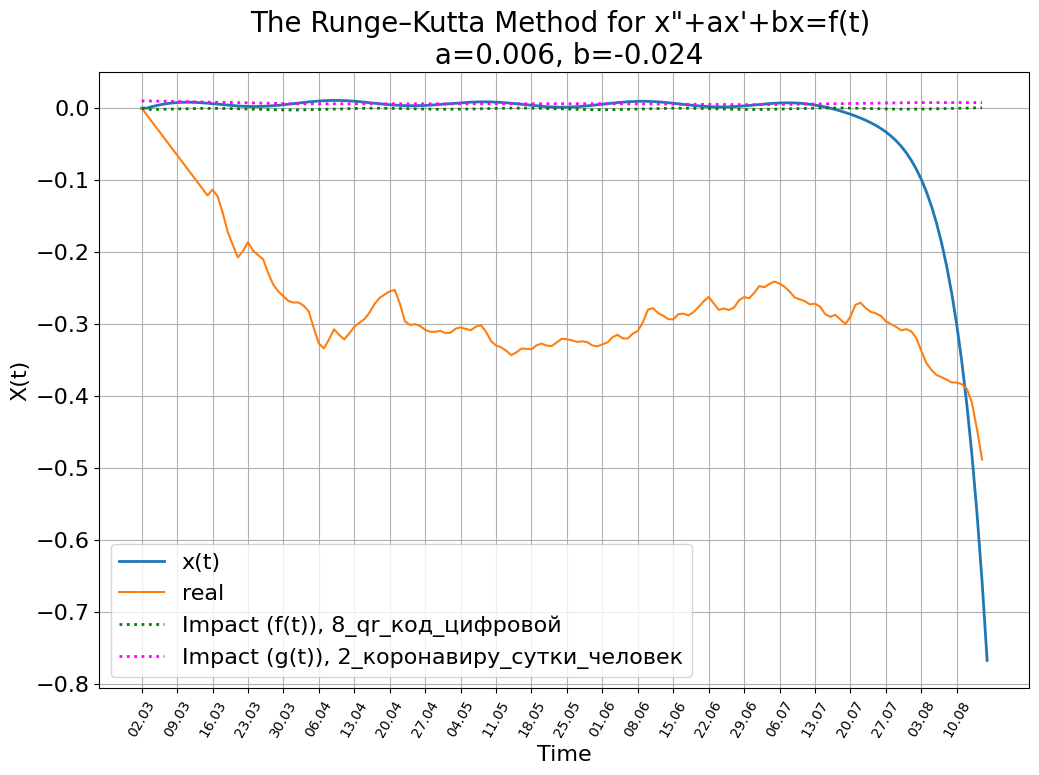

D = 0.10, h = 0.994
delta = 0.00, omega = nan


In [22]:
from scipy.optimize import differential_evolution

fi, gi = 7, 1

# Impact on X and X'
def f(t, a, b, c):
    # X------------------
    x = np.array(news.iloc[:,fi].to_list()) # qr code news
    x /= x.max()
    x = x[int(t)]
    # X'-----------------
    dx = np.array(news.iloc[:,gi].to_list()) # covid news
    dx /= dx.max()
    dx = dx[int(t)]
    # return [f(t), g(t)]
    return [a*x-b*dcos[int(t)-1], c*dx]

def train(args, final=False):
    x_bias, cos_bias, dx_bias = args[0], args[1], args[2]
    x = [0.0]     # Initial state of X(t)
    dx = [0.0]    # Initial state of dX/dt
    T = np.linspace(0, len(u)-1, len(u))
    h = (T[-1] - T[0]) / len(T)
    A = np.array([[0., 1.],
                  [-b, -a]])

    for t in T:
        Y = np.array([[x[-1],dx[-1]]]).T
        k1 = (np.dot(A,Y)+np.array([f(t, x_bias, cos_bias, dx_bias)]).T)*h
        k2 = (np.dot(A,(Y+k1/2))+np.array([f(t+h/2, x_bias, cos_bias, dx_bias)]).T)*h
        k3 = (np.dot(A,(Y+k2/2))+np.array([f(t+h/2, x_bias, cos_bias, dx_bias)]).T)*h
        k4 = (np.dot(A,(Y+k3))+np.array([f(t+h, x_bias, cos_bias, dx_bias)]).T)*h
        Y1 = Y+(k1+2*k2+2*k3+k4)/6
        x.append(Y1[0,0])
        dx.append(Y1[1,0])
    x = np.array(x)*b 
    dx = np.array(dx)*b 

    truth = np.array(u.values-u.values[0])
    pred = np.array(x[1:])
    loss = np.linalg.norm(pred - truth) / np.sqrt(len(truth))
    
    print(f"x_bias: {x_bias}\tcos_bias: {cos_bias}\tdx_bias: {dx_bias}\tloss: {loss}%")
    
    if final:
        return x, T, h
    
    return loss

# Diff evolution for optimization
bounds = [(-15.0, 15.0), (-7.0, 10.0), (0.01, 1.0)]
result = differential_evolution(train, bounds, workers=4)
x_bias, cos_bias, dx_bias = result.x[0], result.x[1], result.x[2]

x, T, h = train([x_bias, cos_bias, dx_bias], final=True)

# Plotting
plt.figure(figsize=(12,8))
plt.plot(x, lw=2, label='x(t)')
#plt.plot(dx, lw=2, label='dx/dt')
plt.plot((u.values-u.values[0]), label='real')
plt.plot([f(t, x_bias, cos_bias, dx_bias)[0]/50 for t in T], c='green', ls=':',lw=2,
         label=f'Impact (f(t)), {news.columns[fi]}')
plt.plot([f(t, x_bias, cos_bias, dx_bias)[1] for t in T], c='magenta', ls=':',lw=2,
         label=f'Impact (g(t)), {news.columns[gi]}')
xti=np.arange(0,len(T)+1,len(T)//8)
#plt.xticks(xti, np.arange(len(xti)), size=16)
t=np.arange(0,len(u),7)
plt.xticks(t, u.index.strftime('%d.%m').values[t], rotation=60)
plt.yticks(size=16)
plt.title('The Runge–Kutta Method for x\"+ax\'+bx=f(t) \n a=%.3f, b=%.3f'%(a,b), size=20)
plt.xlabel('Time', size=16)
plt.ylabel('X(t)', size=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
print('D = %.2f, h = %.3f'%(a**2-4*b, h))
print('delta = %.2f, omega = %.3f'%(a/2, np.sqrt(b)))